##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [2]:
!pip install -q tf-nightly
import tensorflow as tf

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.01845549, -0.00264155,  0.00098151, -0.01127415, -0.03629755],
       [-0.00967798, -0.04427677, -0.03236356,  0.00662072,  0.01001717],
       [ 0.01174301, -0.01823787, -0.00415904, -0.01067955,  0.04726615]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the  [Loading text tutorial](../load_data/text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDD10HL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDD10HL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDD10HL/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [9]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [10]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [11]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [12]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[8002, 7968,  111, ...,    0,    0,    0],
       [5646,    2,  481, ...,  155,  166, 7975],
       [  19,   27,   18, ...,    0,    0,    0],
       ...,
       [  62,    9,    4, ...,    0,    0,    0],
       [3057, 1045, 4716, ...,    0,    0,    0],
       [5289,    2,   81, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [13]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 0s - loss: 0.6935 - accuracy: 0.5000

  13/2500 [..............................] - ETA: 9s - loss: 0.6929 - accuracy: 0.5462

  27/2500 [..............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5148

  40/2500 [..............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.5175

  55/2500 [..............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5182

  70/2500 [..............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.5043

  84/2500 [>.............................] - ETA: 8s - loss: 0.6933 - accuracy: 0.4952

  99/2500 [>.............................] - ETA: 8s - loss: 0.6930 - accuracy: 0.4879

 113/2500 [>.............................] - ETA: 8s - loss: 0.6930 - accuracy: 0.4885

 126/2500 [>.............................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4937

 140/2500 [>.............................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4950

 154/2500 [>.............................] - ETA: 8s - loss: 0.6931 - accuracy: 0.4974

 168/2500 [=>............................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5000

 182/2500 [=>............................] - ETA: 8s - loss: 0.6930 - accuracy: 0.5016

 196/2500 [=>............................] - ETA: 8s - loss: 0.6927 - accuracy: 0.5066

 210/2500 [=>............................] - ETA: 8s - loss: 0.6926 - accuracy: 0.5071

 224/2500 [=>............................] - ETA: 8s - loss: 0.6928 - accuracy: 0.5040

 238/2500 [=>............................] - ETA: 8s - loss: 0.6927 - accuracy: 0.5025

 253/2500 [==>...........................] - ETA: 8s - loss: 0.6925 - accuracy: 0.5047

 268/2500 [==>...........................] - ETA: 8s - loss: 0.6924 - accuracy: 0.5026

 282/2500 [==>...........................] - ETA: 8s - loss: 0.6921 - accuracy: 0.5028

 295/2500 [==>...........................] - ETA: 8s - loss: 0.6920 - accuracy: 0.4983

 309/2500 [==>...........................] - ETA: 8s - loss: 0.6916 - accuracy: 0.4942

 322/2500 [==>...........................] - ETA: 8s - loss: 0.6914 - accuracy: 0.4932

 336/2500 [===>..........................] - ETA: 8s - loss: 0.6912 - accuracy: 0.4923

 350/2500 [===>..........................] - ETA: 7s - loss: 0.6910 - accuracy: 0.4917

 364/2500 [===>..........................] - ETA: 7s - loss: 0.6907 - accuracy: 0.4909

 378/2500 [===>..........................] - ETA: 7s - loss: 0.6906 - accuracy: 0.4921

 392/2500 [===>..........................] - ETA: 7s - loss: 0.6903 - accuracy: 0.4929

 406/2500 [===>..........................] - ETA: 7s - loss: 0.6899 - accuracy: 0.4953

 420/2500 [====>.........................] - ETA: 7s - loss: 0.6895 - accuracy: 0.4962

 434/2500 [====>.........................] - ETA: 7s - loss: 0.6894 - accuracy: 0.4945

 448/2500 [====>.........................] - ETA: 7s - loss: 0.6891 - accuracy: 0.4951

 462/2500 [====>.........................] - ETA: 7s - loss: 0.6888 - accuracy: 0.4942

 475/2500 [====>.........................] - ETA: 7s - loss: 0.6886 - accuracy: 0.4954

 489/2500 [====>.........................] - ETA: 7s - loss: 0.6882 - accuracy: 0.4933

 503/2500 [=====>........................] - ETA: 7s - loss: 0.6878 - accuracy: 0.4948

 517/2500 [=====>........................] - ETA: 7s - loss: 0.6871 - accuracy: 0.4956

 531/2500 [=====>........................] - ETA: 7s - loss: 0.6865 - accuracy: 0.4951

 545/2500 [=====>........................] - ETA: 7s - loss: 0.6860 - accuracy: 0.4952

 558/2500 [=====>........................] - ETA: 7s - loss: 0.6855 - accuracy: 0.4953

 571/2500 [=====>........................] - ETA: 7s - loss: 0.6848 - accuracy: 0.4954

 584/2500 [======>.......................] - ETA: 7s - loss: 0.6842 - accuracy: 0.4947

 598/2500 [======>.......................] - ETA: 7s - loss: 0.6835 - accuracy: 0.4950

 611/2500 [======>.......................] - ETA: 7s - loss: 0.6827 - accuracy: 0.4969

 624/2500 [======>.......................] - ETA: 6s - loss: 0.6819 - accuracy: 0.4982

 638/2500 [======>.......................] - ETA: 6s - loss: 0.6814 - accuracy: 0.4976

 652/2500 [======>.......................] - ETA: 6s - loss: 0.6804 - accuracy: 0.4972

 666/2500 [======>.......................] - ETA: 6s - loss: 0.6792 - accuracy: 0.4976

 680/2500 [=======>......................] - ETA: 6s - loss: 0.6779 - accuracy: 0.4999

 693/2500 [=======>......................] - ETA: 6s - loss: 0.6769 - accuracy: 0.5013

 707/2500 [=======>......................] - ETA: 6s - loss: 0.6763 - accuracy: 0.5007

 720/2500 [=======>......................] - ETA: 6s - loss: 0.6756 - accuracy: 0.5011

 734/2500 [=======>......................] - ETA: 6s - loss: 0.6743 - accuracy: 0.5025

 748/2500 [=======>......................] - ETA: 6s - loss: 0.6735 - accuracy: 0.5035

 762/2500 [========>.....................] - ETA: 6s - loss: 0.6723 - accuracy: 0.5038

 776/2500 [========>.....................] - ETA: 6s - loss: 0.6709 - accuracy: 0.5082

 790/2500 [========>.....................] - ETA: 6s - loss: 0.6695 - accuracy: 0.5092

 804/2500 [========>.....................] - ETA: 6s - loss: 0.6682 - accuracy: 0.5096

 818/2500 [========>.....................] - ETA: 6s - loss: 0.6670 - accuracy: 0.5127

 832/2500 [========>.....................] - ETA: 6s - loss: 0.6654 - accuracy: 0.5138

 845/2500 [=========>....................] - ETA: 6s - loss: 0.6640 - accuracy: 0.5150

 858/2500 [=========>....................] - ETA: 6s - loss: 0.6633 - accuracy: 0.5161

 872/2500 [=========>....................] - ETA: 6s - loss: 0.6622 - accuracy: 0.5177

 886/2500 [=========>....................] - ETA: 6s - loss: 0.6603 - accuracy: 0.5200

 900/2500 [=========>....................] - ETA: 5s - loss: 0.6586 - accuracy: 0.5220

 915/2500 [=========>....................] - ETA: 5s - loss: 0.6565 - accuracy: 0.5239

 929/2500 [==========>...................] - ETA: 5s - loss: 0.6547 - accuracy: 0.5278

 943/2500 [==========>...................] - ETA: 5s - loss: 0.6537 - accuracy: 0.5286

 958/2500 [==========>...................] - ETA: 5s - loss: 0.6516 - accuracy: 0.5318

 972/2500 [==========>...................] - ETA: 5s - loss: 0.6495 - accuracy: 0.5350

 985/2500 [==========>...................] - ETA: 5s - loss: 0.6477 - accuracy: 0.5369

 999/2500 [==========>...................] - ETA: 5s - loss: 0.6455 - accuracy: 0.5399

1013/2500 [===========>..................] - ETA: 5s - loss: 0.6440 - accuracy: 0.5432

1028/2500 [===========>..................] - ETA: 5s - loss: 0.6422 - accuracy: 0.5456

1042/2500 [===========>..................] - ETA: 5s - loss: 0.6402 - accuracy: 0.5478

1056/2500 [===========>..................] - ETA: 5s - loss: 0.6378 - accuracy: 0.5517

1070/2500 [===========>..................] - ETA: 5s - loss: 0.6355 - accuracy: 0.5540

1084/2500 [============>.................] - ETA: 5s - loss: 0.6341 - accuracy: 0.5565

1098/2500 [============>.................] - ETA: 5s - loss: 0.6324 - accuracy: 0.5585

1112/2500 [============>.................] - ETA: 5s - loss: 0.6306 - accuracy: 0.5603

1126/2500 [============>.................] - ETA: 5s - loss: 0.6285 - accuracy: 0.5634

1139/2500 [============>.................] - ETA: 5s - loss: 0.6266 - accuracy: 0.5649

1152/2500 [============>.................] - ETA: 5s - loss: 0.6245 - accuracy: 0.5678

1166/2500 [============>.................] - ETA: 4s - loss: 0.6224 - accuracy: 0.5705

1180/2500 [=============>................] - ETA: 4s - loss: 0.6199 - accuracy: 0.5735

1193/2500 [=============>................] - ETA: 4s - loss: 0.6183 - accuracy: 0.5753

1207/2500 [=============>................] - ETA: 4s - loss: 0.6164 - accuracy: 0.5778

1221/2500 [=============>................] - ETA: 4s - loss: 0.6149 - accuracy: 0.5792

1235/2500 [=============>................] - ETA: 4s - loss: 0.6132 - accuracy: 0.5814

1249/2500 [=============>................] - ETA: 4s - loss: 0.6119 - accuracy: 0.5828

1262/2500 [==============>...............] - ETA: 4s - loss: 0.6097 - accuracy: 0.5845

1276/2500 [==============>...............] - ETA: 4s - loss: 0.6077 - accuracy: 0.5872

1291/2500 [==============>...............] - ETA: 4s - loss: 0.6061 - accuracy: 0.5893

1306/2500 [==============>...............] - ETA: 4s - loss: 0.6046 - accuracy: 0.5910

1320/2500 [==============>...............] - ETA: 4s - loss: 0.6031 - accuracy: 0.5927

1333/2500 [==============>...............] - ETA: 4s - loss: 0.6018 - accuracy: 0.5940

1346/2500 [===============>..............] - ETA: 4s - loss: 0.6004 - accuracy: 0.5961

1360/2500 [===============>..............] - ETA: 4s - loss: 0.5989 - accuracy: 0.5982

1374/2500 [===============>..............] - ETA: 4s - loss: 0.5969 - accuracy: 0.6000

1387/2500 [===============>..............] - ETA: 4s - loss: 0.5951 - accuracy: 0.6020

1401/2500 [===============>..............] - ETA: 4s - loss: 0.5937 - accuracy: 0.6041

1415/2500 [===============>..............] - ETA: 4s - loss: 0.5915 - accuracy: 0.6062

1429/2500 [================>.............] - ETA: 3s - loss: 0.5901 - accuracy: 0.6071

1443/2500 [================>.............] - ETA: 3s - loss: 0.5884 - accuracy: 0.6097

1457/2500 [================>.............] - ETA: 3s - loss: 0.5868 - accuracy: 0.6108

1471/2500 [================>.............] - ETA: 3s - loss: 0.5851 - accuracy: 0.6124

1485/2500 [================>.............] - ETA: 3s - loss: 0.5836 - accuracy: 0.6147

1499/2500 [================>.............] - ETA: 3s - loss: 0.5823 - accuracy: 0.6157

1514/2500 [=================>............] - ETA: 3s - loss: 0.5809 - accuracy: 0.6170

1528/2500 [=================>............] - ETA: 3s - loss: 0.5791 - accuracy: 0.6188

1542/2500 [=================>............] - ETA: 3s - loss: 0.5779 - accuracy: 0.6204

1556/2500 [=================>............] - ETA: 3s - loss: 0.5766 - accuracy: 0.6217

1570/2500 [=================>............] - ETA: 3s - loss: 0.5755 - accuracy: 0.6236

1584/2500 [==================>...........] - ETA: 3s - loss: 0.5743 - accuracy: 0.6247

1597/2500 [==================>...........] - ETA: 3s - loss: 0.5725 - accuracy: 0.6267

1610/2500 [==================>...........] - ETA: 3s - loss: 0.5708 - accuracy: 0.6286

1624/2500 [==================>...........] - ETA: 3s - loss: 0.5699 - accuracy: 0.6299

1638/2500 [==================>...........] - ETA: 3s - loss: 0.5685 - accuracy: 0.6313

1652/2500 [==================>...........] - ETA: 3s - loss: 0.5668 - accuracy: 0.6329

1665/2500 [==================>...........] - ETA: 3s - loss: 0.5652 - accuracy: 0.6347

1678/2500 [===================>..........] - ETA: 3s - loss: 0.5641 - accuracy: 0.6362

1691/2500 [===================>..........] - ETA: 3s - loss: 0.5630 - accuracy: 0.6381

1705/2500 [===================>..........] - ETA: 2s - loss: 0.5617 - accuracy: 0.6392

1719/2500 [===================>..........] - ETA: 2s - loss: 0.5605 - accuracy: 0.6408

1733/2500 [===================>..........] - ETA: 2s - loss: 0.5590 - accuracy: 0.6421

1746/2500 [===================>..........] - ETA: 2s - loss: 0.5580 - accuracy: 0.6428

1759/2500 [====================>.........] - ETA: 2s - loss: 0.5566 - accuracy: 0.6445

1774/2500 [====================>.........] - ETA: 2s - loss: 0.5555 - accuracy: 0.6459

1788/2500 [====================>.........] - ETA: 2s - loss: 0.5540 - accuracy: 0.6475

1802/2500 [====================>.........] - ETA: 2s - loss: 0.5528 - accuracy: 0.6488

1815/2500 [====================>.........] - ETA: 2s - loss: 0.5516 - accuracy: 0.6502

1828/2500 [====================>.........] - ETA: 2s - loss: 0.5505 - accuracy: 0.6514

1842/2500 [=====================>........] - ETA: 2s - loss: 0.5490 - accuracy: 0.6531

1856/2500 [=====================>........] - ETA: 2s - loss: 0.5478 - accuracy: 0.6544

1870/2500 [=====================>........] - ETA: 2s - loss: 0.5462 - accuracy: 0.6554

1884/2500 [=====================>........] - ETA: 2s - loss: 0.5449 - accuracy: 0.6569

1897/2500 [=====================>........] - ETA: 2s - loss: 0.5441 - accuracy: 0.6577

1911/2500 [=====================>........] - ETA: 2s - loss: 0.5429 - accuracy: 0.6592

1925/2500 [======================>.......] - ETA: 2s - loss: 0.5413 - accuracy: 0.6606

1939/2500 [======================>.......] - ETA: 2s - loss: 0.5405 - accuracy: 0.6615

1953/2500 [======================>.......] - ETA: 2s - loss: 0.5399 - accuracy: 0.6626

1967/2500 [======================>.......] - ETA: 1s - loss: 0.5387 - accuracy: 0.6639

1981/2500 [======================>.......] - ETA: 1s - loss: 0.5375 - accuracy: 0.6650

1994/2500 [======================>.......] - ETA: 1s - loss: 0.5368 - accuracy: 0.6661

2006/2500 [=======================>......] - ETA: 1s - loss: 0.5361 - accuracy: 0.6669

2019/2500 [=======================>......] - ETA: 1s - loss: 0.5347 - accuracy: 0.6681

2033/2500 [=======================>......] - ETA: 1s - loss: 0.5335 - accuracy: 0.6691

2047/2500 [=======================>......] - ETA: 1s - loss: 0.5325 - accuracy: 0.6702

2060/2500 [=======================>......] - ETA: 1s - loss: 0.5314 - accuracy: 0.6711

2073/2500 [=======================>......] - ETA: 1s - loss: 0.5308 - accuracy: 0.6720

2087/2500 [========================>.....] - ETA: 1s - loss: 0.5295 - accuracy: 0.6730

2100/2500 [========================>.....] - ETA: 1s - loss: 0.5281 - accuracy: 0.6743

2114/2500 [========================>.....] - ETA: 1s - loss: 0.5271 - accuracy: 0.6755

2128/2500 [========================>.....] - ETA: 1s - loss: 0.5263 - accuracy: 0.6764

2142/2500 [========================>.....] - ETA: 1s - loss: 0.5251 - accuracy: 0.6772

2155/2500 [========================>.....] - ETA: 1s - loss: 0.5243 - accuracy: 0.6785

2168/2500 [=========================>....] - ETA: 1s - loss: 0.5229 - accuracy: 0.6795

2182/2500 [=========================>....] - ETA: 1s - loss: 0.5216 - accuracy: 0.6807

2196/2500 [=========================>....] - ETA: 1s - loss: 0.5204 - accuracy: 0.6816

2209/2500 [=========================>....] - ETA: 1s - loss: 0.5195 - accuracy: 0.6825

2223/2500 [=========================>....] - ETA: 1s - loss: 0.5186 - accuracy: 0.6837

2237/2500 [=========================>....] - ETA: 0s - loss: 0.5173 - accuracy: 0.6846

2251/2500 [==========================>...] - ETA: 0s - loss: 0.5160 - accuracy: 0.6856

2265/2500 [==========================>...] - ETA: 0s - loss: 0.5155 - accuracy: 0.6864

2278/2500 [==========================>...] - ETA: 0s - loss: 0.5150 - accuracy: 0.6874

2292/2500 [==========================>...] - ETA: 0s - loss: 0.5144 - accuracy: 0.6880

2305/2500 [==========================>...] - ETA: 0s - loss: 0.5135 - accuracy: 0.6887

2319/2500 [==========================>...] - ETA: 0s - loss: 0.5130 - accuracy: 0.6896

2333/2500 [==========================>...] - ETA: 0s - loss: 0.5120 - accuracy: 0.6905

2347/2500 [===========================>..] - ETA: 0s - loss: 0.5114 - accuracy: 0.6914

2362/2500 [===========================>..] - ETA: 0s - loss: 0.5101 - accuracy: 0.6924

2376/2500 [===========================>..] - ETA: 0s - loss: 0.5092 - accuracy: 0.6934

2390/2500 [===========================>..] - ETA: 0s - loss: 0.5079 - accuracy: 0.6947

2404/2500 [===========================>..] - ETA: 0s - loss: 0.5063 - accuracy: 0.6960

2419/2500 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.6969

2434/2500 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.6977

2449/2500 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.6987

2463/2500 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.6995

2478/2500 [============================>.] - ETA: 0s - loss: 0.5022 - accuracy: 0.7000

2493/2500 [============================>.] - ETA: 0s - loss: 0.5010 - accuracy: 0.7010

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5008 - accuracy: 0.7014 - val_loss: 0.3832 - val_accuracy: 0.8050


Epoch 2/10
   1/2500 [..............................] - ETA: 0s - loss: 0.0533 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.2901 - accuracy: 0.8400

  28/2500 [..............................] - ETA: 9s - loss: 0.3036 - accuracy: 0.8643

  42/2500 [..............................] - ETA: 9s - loss: 0.3268 - accuracy: 0.8524

  56/2500 [..............................] - ETA: 9s - loss: 0.3274 - accuracy: 0.8607

  70/2500 [..............................] - ETA: 8s - loss: 0.3208 - accuracy: 0.8700

  84/2500 [>.............................] - ETA: 8s - loss: 0.3243 - accuracy: 0.8595

  98/2500 [>.............................] - ETA: 8s - loss: 0.3198 - accuracy: 0.8653

 111/2500 [>.............................] - ETA: 8s - loss: 0.3255 - accuracy: 0.8613

 124/2500 [>.............................] - ETA: 8s - loss: 0.3370 - accuracy: 0.8548

 138/2500 [>.............................] - ETA: 8s - loss: 0.3340 - accuracy: 0.8529

 152/2500 [>.............................] - ETA: 8s - loss: 0.3326 - accuracy: 0.8579

 166/2500 [>.............................] - ETA: 8s - loss: 0.3327 - accuracy: 0.8518

 179/2500 [=>............................] - ETA: 8s - loss: 0.3331 - accuracy: 0.8536

 193/2500 [=>............................] - ETA: 8s - loss: 0.3328 - accuracy: 0.8513

 207/2500 [=>............................] - ETA: 8s - loss: 0.3280 - accuracy: 0.8565

 222/2500 [=>............................] - ETA: 8s - loss: 0.3276 - accuracy: 0.8568

 236/2500 [=>............................] - ETA: 8s - loss: 0.3257 - accuracy: 0.8564

 250/2500 [==>...........................] - ETA: 8s - loss: 0.3265 - accuracy: 0.8584

 264/2500 [==>...........................] - ETA: 8s - loss: 0.3228 - accuracy: 0.8606

 278/2500 [==>...........................] - ETA: 8s - loss: 0.3187 - accuracy: 0.8622

 291/2500 [==>...........................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8615

 305/2500 [==>...........................] - ETA: 8s - loss: 0.3196 - accuracy: 0.8630

 319/2500 [==>...........................] - ETA: 8s - loss: 0.3183 - accuracy: 0.8643

 333/2500 [==>...........................] - ETA: 8s - loss: 0.3211 - accuracy: 0.8619

 347/2500 [===>..........................] - ETA: 7s - loss: 0.3210 - accuracy: 0.8637

 361/2500 [===>..........................] - ETA: 7s - loss: 0.3191 - accuracy: 0.8651

 375/2500 [===>..........................] - ETA: 7s - loss: 0.3171 - accuracy: 0.8656

 390/2500 [===>..........................] - ETA: 7s - loss: 0.3191 - accuracy: 0.8646

 403/2500 [===>..........................] - ETA: 7s - loss: 0.3191 - accuracy: 0.8660

 417/2500 [====>.........................] - ETA: 7s - loss: 0.3197 - accuracy: 0.8655

 431/2500 [====>.........................] - ETA: 7s - loss: 0.3185 - accuracy: 0.8664

 444/2500 [====>.........................] - ETA: 7s - loss: 0.3177 - accuracy: 0.8658

 456/2500 [====>.........................] - ETA: 7s - loss: 0.3177 - accuracy: 0.8664

 470/2500 [====>.........................] - ETA: 7s - loss: 0.3170 - accuracy: 0.8655

 484/2500 [====>.........................] - ETA: 7s - loss: 0.3163 - accuracy: 0.8671

 498/2500 [====>.........................] - ETA: 7s - loss: 0.3156 - accuracy: 0.8669

 512/2500 [=====>........................] - ETA: 7s - loss: 0.3145 - accuracy: 0.8670

 527/2500 [=====>........................] - ETA: 7s - loss: 0.3154 - accuracy: 0.8676

 541/2500 [=====>........................] - ETA: 7s - loss: 0.3155 - accuracy: 0.8673

 555/2500 [=====>........................] - ETA: 7s - loss: 0.3180 - accuracy: 0.8658

 568/2500 [=====>........................] - ETA: 7s - loss: 0.3172 - accuracy: 0.8669

 582/2500 [=====>........................] - ETA: 7s - loss: 0.3160 - accuracy: 0.8677

 595/2500 [======>.......................] - ETA: 7s - loss: 0.3137 - accuracy: 0.8691

 609/2500 [======>.......................] - ETA: 7s - loss: 0.3131 - accuracy: 0.8696

 623/2500 [======>.......................] - ETA: 7s - loss: 0.3128 - accuracy: 0.8697

 635/2500 [======>.......................] - ETA: 6s - loss: 0.3118 - accuracy: 0.8701

 648/2500 [======>.......................] - ETA: 6s - loss: 0.3112 - accuracy: 0.8704

 662/2500 [======>.......................] - ETA: 6s - loss: 0.3105 - accuracy: 0.8710

 675/2500 [=======>......................] - ETA: 6s - loss: 0.3103 - accuracy: 0.8714

 688/2500 [=======>......................] - ETA: 6s - loss: 0.3103 - accuracy: 0.8715

 702/2500 [=======>......................] - ETA: 6s - loss: 0.3118 - accuracy: 0.8705

 716/2500 [=======>......................] - ETA: 6s - loss: 0.3118 - accuracy: 0.8701

 730/2500 [=======>......................] - ETA: 6s - loss: 0.3114 - accuracy: 0.8700

 744/2500 [=======>......................] - ETA: 6s - loss: 0.3119 - accuracy: 0.8702

 758/2500 [========>.....................] - ETA: 6s - loss: 0.3103 - accuracy: 0.8711

 772/2500 [========>.....................] - ETA: 6s - loss: 0.3105 - accuracy: 0.8709

 785/2500 [========>.....................] - ETA: 6s - loss: 0.3099 - accuracy: 0.8715

 799/2500 [========>.....................] - ETA: 6s - loss: 0.3091 - accuracy: 0.8713

 812/2500 [========>.....................] - ETA: 6s - loss: 0.3093 - accuracy: 0.8711

 826/2500 [========>.....................] - ETA: 6s - loss: 0.3084 - accuracy: 0.8715

 839/2500 [=========>....................] - ETA: 6s - loss: 0.3080 - accuracy: 0.8721

 853/2500 [=========>....................] - ETA: 6s - loss: 0.3069 - accuracy: 0.8726

 867/2500 [=========>....................] - ETA: 6s - loss: 0.3058 - accuracy: 0.8730

 881/2500 [=========>....................] - ETA: 6s - loss: 0.3051 - accuracy: 0.8738

 895/2500 [=========>....................] - ETA: 6s - loss: 0.3053 - accuracy: 0.8736

 909/2500 [=========>....................] - ETA: 5s - loss: 0.3048 - accuracy: 0.8737

 923/2500 [==========>...................] - ETA: 5s - loss: 0.3032 - accuracy: 0.8746

 936/2500 [==========>...................] - ETA: 5s - loss: 0.3039 - accuracy: 0.8740

 949/2500 [==========>...................] - ETA: 5s - loss: 0.3031 - accuracy: 0.8745

 962/2500 [==========>...................] - ETA: 5s - loss: 0.3025 - accuracy: 0.8745

 974/2500 [==========>...................] - ETA: 5s - loss: 0.3023 - accuracy: 0.8746

 987/2500 [==========>...................] - ETA: 5s - loss: 0.3028 - accuracy: 0.8749

1001/2500 [===========>..................] - ETA: 5s - loss: 0.3023 - accuracy: 0.8749

1014/2500 [===========>..................] - ETA: 5s - loss: 0.3022 - accuracy: 0.8747

1027/2500 [===========>..................] - ETA: 5s - loss: 0.3019 - accuracy: 0.8750

1041/2500 [===========>..................] - ETA: 5s - loss: 0.3005 - accuracy: 0.8757

1055/2500 [===========>..................] - ETA: 5s - loss: 0.2998 - accuracy: 0.8759

1070/2500 [===========>..................] - ETA: 5s - loss: 0.2998 - accuracy: 0.8761

1084/2500 [============>.................] - ETA: 5s - loss: 0.2993 - accuracy: 0.8761

1098/2500 [============>.................] - ETA: 5s - loss: 0.2994 - accuracy: 0.8763

1111/2500 [============>.................] - ETA: 5s - loss: 0.2992 - accuracy: 0.8766

1125/2500 [============>.................] - ETA: 5s - loss: 0.2983 - accuracy: 0.8771

1139/2500 [============>.................] - ETA: 5s - loss: 0.2977 - accuracy: 0.8770

1152/2500 [============>.................] - ETA: 5s - loss: 0.2977 - accuracy: 0.8775

1166/2500 [============>.................] - ETA: 5s - loss: 0.2974 - accuracy: 0.8772

1180/2500 [=============>................] - ETA: 4s - loss: 0.2966 - accuracy: 0.8780

1194/2500 [=============>................] - ETA: 4s - loss: 0.2965 - accuracy: 0.8778

1208/2500 [=============>................] - ETA: 4s - loss: 0.2967 - accuracy: 0.8778

1222/2500 [=============>................] - ETA: 4s - loss: 0.2959 - accuracy: 0.8777

1235/2500 [=============>................] - ETA: 4s - loss: 0.2965 - accuracy: 0.8774

1249/2500 [=============>................] - ETA: 4s - loss: 0.2957 - accuracy: 0.8777

1263/2500 [==============>...............] - ETA: 4s - loss: 0.2961 - accuracy: 0.8780

1277/2500 [==============>...............] - ETA: 4s - loss: 0.2952 - accuracy: 0.8785

1290/2500 [==============>...............] - ETA: 4s - loss: 0.2957 - accuracy: 0.8782

1303/2500 [==============>...............] - ETA: 4s - loss: 0.2952 - accuracy: 0.8782

1316/2500 [==============>...............] - ETA: 4s - loss: 0.2951 - accuracy: 0.8780

1330/2500 [==============>...............] - ETA: 4s - loss: 0.2942 - accuracy: 0.8784

1343/2500 [===============>..............] - ETA: 4s - loss: 0.2934 - accuracy: 0.8789

1357/2500 [===============>..............] - ETA: 4s - loss: 0.2924 - accuracy: 0.8795

1371/2500 [===============>..............] - ETA: 4s - loss: 0.2926 - accuracy: 0.8796

1385/2500 [===============>..............] - ETA: 4s - loss: 0.2921 - accuracy: 0.8798

1398/2500 [===============>..............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8798

1411/2500 [===============>..............] - ETA: 4s - loss: 0.2916 - accuracy: 0.8800

1424/2500 [================>.............] - ETA: 4s - loss: 0.2917 - accuracy: 0.8801

1437/2500 [================>.............] - ETA: 4s - loss: 0.2912 - accuracy: 0.8801

1451/2500 [================>.............] - ETA: 3s - loss: 0.2911 - accuracy: 0.8802

1465/2500 [================>.............] - ETA: 3s - loss: 0.2905 - accuracy: 0.8802

1478/2500 [================>.............] - ETA: 3s - loss: 0.2896 - accuracy: 0.8804

1492/2500 [================>.............] - ETA: 3s - loss: 0.2898 - accuracy: 0.8802

1505/2500 [=================>............] - ETA: 3s - loss: 0.2899 - accuracy: 0.8801

1519/2500 [=================>............] - ETA: 3s - loss: 0.2897 - accuracy: 0.8801

1532/2500 [=================>............] - ETA: 3s - loss: 0.2893 - accuracy: 0.8805

1546/2500 [=================>............] - ETA: 3s - loss: 0.2894 - accuracy: 0.8806

1560/2500 [=================>............] - ETA: 3s - loss: 0.2890 - accuracy: 0.8808

1573/2500 [=================>............] - ETA: 3s - loss: 0.2893 - accuracy: 0.8805

1587/2500 [==================>...........] - ETA: 3s - loss: 0.2894 - accuracy: 0.8805

1601/2500 [==================>...........] - ETA: 3s - loss: 0.2885 - accuracy: 0.8809

1615/2500 [==================>...........] - ETA: 3s - loss: 0.2886 - accuracy: 0.8807

1628/2500 [==================>...........] - ETA: 3s - loss: 0.2881 - accuracy: 0.8807

1641/2500 [==================>...........] - ETA: 3s - loss: 0.2884 - accuracy: 0.8807

1655/2500 [==================>...........] - ETA: 3s - loss: 0.2882 - accuracy: 0.8808

1668/2500 [===================>..........] - ETA: 3s - loss: 0.2882 - accuracy: 0.8808

1682/2500 [===================>..........] - ETA: 3s - loss: 0.2883 - accuracy: 0.8807

1696/2500 [===================>..........] - ETA: 3s - loss: 0.2880 - accuracy: 0.8806

1709/2500 [===================>..........] - ETA: 2s - loss: 0.2878 - accuracy: 0.8806

1723/2500 [===================>..........] - ETA: 2s - loss: 0.2875 - accuracy: 0.8807

1737/2500 [===================>..........] - ETA: 2s - loss: 0.2871 - accuracy: 0.8806

1751/2500 [====================>.........] - ETA: 2s - loss: 0.2868 - accuracy: 0.8811

1764/2500 [====================>.........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8812

1778/2500 [====================>.........] - ETA: 2s - loss: 0.2860 - accuracy: 0.8811

1791/2500 [====================>.........] - ETA: 2s - loss: 0.2864 - accuracy: 0.8810

1805/2500 [====================>.........] - ETA: 2s - loss: 0.2866 - accuracy: 0.8810

1818/2500 [====================>.........] - ETA: 2s - loss: 0.2863 - accuracy: 0.8812

1831/2500 [====================>.........] - ETA: 2s - loss: 0.2859 - accuracy: 0.8814

1844/2500 [=====================>........] - ETA: 2s - loss: 0.2860 - accuracy: 0.8812

1857/2500 [=====================>........] - ETA: 2s - loss: 0.2860 - accuracy: 0.8813

1870/2500 [=====================>........] - ETA: 2s - loss: 0.2863 - accuracy: 0.8812

1883/2500 [=====================>........] - ETA: 2s - loss: 0.2864 - accuracy: 0.8812

1896/2500 [=====================>........] - ETA: 2s - loss: 0.2863 - accuracy: 0.8809

1909/2500 [=====================>........] - ETA: 2s - loss: 0.2862 - accuracy: 0.8810

1922/2500 [======================>.......] - ETA: 2s - loss: 0.2860 - accuracy: 0.8811

1935/2500 [======================>.......] - ETA: 2s - loss: 0.2863 - accuracy: 0.8811

1947/2500 [======================>.......] - ETA: 2s - loss: 0.2859 - accuracy: 0.8813

1960/2500 [======================>.......] - ETA: 2s - loss: 0.2856 - accuracy: 0.8812

1973/2500 [======================>.......] - ETA: 2s - loss: 0.2861 - accuracy: 0.8809

1986/2500 [======================>.......] - ETA: 1s - loss: 0.2857 - accuracy: 0.8811

1999/2500 [======================>.......] - ETA: 1s - loss: 0.2863 - accuracy: 0.8808

2011/2500 [=======================>......] - ETA: 1s - loss: 0.2863 - accuracy: 0.8806

2024/2500 [=======================>......] - ETA: 1s - loss: 0.2865 - accuracy: 0.8806

2037/2500 [=======================>......] - ETA: 1s - loss: 0.2861 - accuracy: 0.8809

2049/2500 [=======================>......] - ETA: 1s - loss: 0.2862 - accuracy: 0.8808

2062/2500 [=======================>......] - ETA: 1s - loss: 0.2857 - accuracy: 0.8812

2075/2500 [=======================>......] - ETA: 1s - loss: 0.2856 - accuracy: 0.8813

2088/2500 [========================>.....] - ETA: 1s - loss: 0.2852 - accuracy: 0.8815

2101/2500 [========================>.....] - ETA: 1s - loss: 0.2848 - accuracy: 0.8817

2114/2500 [========================>.....] - ETA: 1s - loss: 0.2849 - accuracy: 0.8817

2127/2500 [========================>.....] - ETA: 1s - loss: 0.2849 - accuracy: 0.8818

2140/2500 [========================>.....] - ETA: 1s - loss: 0.2846 - accuracy: 0.8818

2154/2500 [========================>.....] - ETA: 1s - loss: 0.2848 - accuracy: 0.8817

2168/2500 [=========================>....] - ETA: 1s - loss: 0.2843 - accuracy: 0.8818

2181/2500 [=========================>....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8821

2194/2500 [=========================>....] - ETA: 1s - loss: 0.2842 - accuracy: 0.8820

2207/2500 [=========================>....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8820

2221/2500 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8823

2234/2500 [=========================>....] - ETA: 1s - loss: 0.2840 - accuracy: 0.8822

2247/2500 [=========================>....] - ETA: 0s - loss: 0.2837 - accuracy: 0.8822

2260/2500 [==========================>...] - ETA: 0s - loss: 0.2833 - accuracy: 0.8827

2273/2500 [==========================>...] - ETA: 0s - loss: 0.2830 - accuracy: 0.8828

2287/2500 [==========================>...] - ETA: 0s - loss: 0.2829 - accuracy: 0.8826

2301/2500 [==========================>...] - ETA: 0s - loss: 0.2828 - accuracy: 0.8828

2314/2500 [==========================>...] - ETA: 0s - loss: 0.2825 - accuracy: 0.8828

2327/2500 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8828

2341/2500 [===========================>..] - ETA: 0s - loss: 0.2821 - accuracy: 0.8829

2355/2500 [===========================>..] - ETA: 0s - loss: 0.2820 - accuracy: 0.8829

2369/2500 [===========================>..] - ETA: 0s - loss: 0.2818 - accuracy: 0.8832

2382/2500 [===========================>..] - ETA: 0s - loss: 0.2815 - accuracy: 0.8833

2395/2500 [===========================>..] - ETA: 0s - loss: 0.2816 - accuracy: 0.8833

2409/2500 [===========================>..] - ETA: 0s - loss: 0.2813 - accuracy: 0.8836

2423/2500 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.8836

2438/2500 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.8833

2452/2500 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8834

2467/2500 [============================>.] - ETA: 0s - loss: 0.2811 - accuracy: 0.8834

2482/2500 [============================>.] - ETA: 0s - loss: 0.2811 - accuracy: 0.8835

2496/2500 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.8835

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2806 - accuracy: 0.8836 - val_loss: 0.3297 - val_accuracy: 0.8950


Epoch 3/10


   1/2500 [..............................] - ETA: 0s - loss: 0.4116 - accuracy: 0.8000

  15/2500 [..............................] - ETA: 8s - loss: 0.2494 - accuracy: 0.8933

  29/2500 [..............................] - ETA: 8s - loss: 0.2420 - accuracy: 0.9034

  43/2500 [..............................] - ETA: 8s - loss: 0.2340 - accuracy: 0.9140

  56/2500 [..............................] - ETA: 9s - loss: 0.2299 - accuracy: 0.9250

  69/2500 [..............................] - ETA: 9s - loss: 0.2296 - accuracy: 0.9246

  81/2500 [..............................] - ETA: 9s - loss: 0.2252 - accuracy: 0.9222

  95/2500 [>.............................] - ETA: 9s - loss: 0.2258 - accuracy: 0.9242

 109/2500 [>.............................] - ETA: 9s - loss: 0.2410 - accuracy: 0.9101

 122/2500 [>.............................] - ETA: 9s - loss: 0.2380 - accuracy: 0.9090

 135/2500 [>.............................] - ETA: 9s - loss: 0.2315 - accuracy: 0.9119

 149/2500 [>.............................] - ETA: 9s - loss: 0.2326 - accuracy: 0.9094

 162/2500 [>.............................] - ETA: 9s - loss: 0.2402 - accuracy: 0.9056

 175/2500 [=>............................] - ETA: 8s - loss: 0.2407 - accuracy: 0.9063

 189/2500 [=>............................] - ETA: 8s - loss: 0.2397 - accuracy: 0.9079

 203/2500 [=>............................] - ETA: 8s - loss: 0.2387 - accuracy: 0.9069

 217/2500 [=>............................] - ETA: 8s - loss: 0.2422 - accuracy: 0.9060

 230/2500 [=>............................] - ETA: 8s - loss: 0.2512 - accuracy: 0.9004

 244/2500 [=>............................] - ETA: 8s - loss: 0.2494 - accuracy: 0.9004

 257/2500 [==>...........................] - ETA: 8s - loss: 0.2469 - accuracy: 0.9023

 271/2500 [==>...........................] - ETA: 8s - loss: 0.2500 - accuracy: 0.9011

 285/2500 [==>...........................] - ETA: 8s - loss: 0.2530 - accuracy: 0.9014

 299/2500 [==>...........................] - ETA: 8s - loss: 0.2522 - accuracy: 0.8997

 313/2500 [==>...........................] - ETA: 8s - loss: 0.2517 - accuracy: 0.9006

 326/2500 [==>...........................] - ETA: 8s - loss: 0.2537 - accuracy: 0.8994

 338/2500 [===>..........................] - ETA: 8s - loss: 0.2564 - accuracy: 0.8979

 352/2500 [===>..........................] - ETA: 8s - loss: 0.2538 - accuracy: 0.8991

 366/2500 [===>..........................] - ETA: 8s - loss: 0.2538 - accuracy: 0.8995

 380/2500 [===>..........................] - ETA: 8s - loss: 0.2515 - accuracy: 0.9005

 394/2500 [===>..........................] - ETA: 8s - loss: 0.2511 - accuracy: 0.9005

 407/2500 [===>..........................] - ETA: 8s - loss: 0.2504 - accuracy: 0.9010

 421/2500 [====>.........................] - ETA: 7s - loss: 0.2502 - accuracy: 0.9024

 435/2500 [====>.........................] - ETA: 7s - loss: 0.2490 - accuracy: 0.9011

 449/2500 [====>.........................] - ETA: 7s - loss: 0.2481 - accuracy: 0.9029

 463/2500 [====>.........................] - ETA: 7s - loss: 0.2491 - accuracy: 0.9017

 477/2500 [====>.........................] - ETA: 7s - loss: 0.2485 - accuracy: 0.9021

 491/2500 [====>.........................] - ETA: 7s - loss: 0.2470 - accuracy: 0.9016

 505/2500 [=====>........................] - ETA: 7s - loss: 0.2469 - accuracy: 0.9022

 519/2500 [=====>........................] - ETA: 7s - loss: 0.2455 - accuracy: 0.9039

 533/2500 [=====>........................] - ETA: 7s - loss: 0.2466 - accuracy: 0.9030

 546/2500 [=====>........................] - ETA: 7s - loss: 0.2460 - accuracy: 0.9040

 560/2500 [=====>........................] - ETA: 7s - loss: 0.2461 - accuracy: 0.9043

 574/2500 [=====>........................] - ETA: 7s - loss: 0.2455 - accuracy: 0.9045

 588/2500 [======>.......................] - ETA: 7s - loss: 0.2436 - accuracy: 0.9054

 602/2500 [======>.......................] - ETA: 7s - loss: 0.2422 - accuracy: 0.9065

 616/2500 [======>.......................] - ETA: 7s - loss: 0.2428 - accuracy: 0.9065

 629/2500 [======>.......................] - ETA: 7s - loss: 0.2417 - accuracy: 0.9068

 643/2500 [======>.......................] - ETA: 7s - loss: 0.2410 - accuracy: 0.9068

 657/2500 [======>.......................] - ETA: 6s - loss: 0.2394 - accuracy: 0.9082

 671/2500 [=======>......................] - ETA: 6s - loss: 0.2404 - accuracy: 0.9077

 684/2500 [=======>......................] - ETA: 6s - loss: 0.2409 - accuracy: 0.9077

 698/2500 [=======>......................] - ETA: 6s - loss: 0.2408 - accuracy: 0.9080

 712/2500 [=======>......................] - ETA: 6s - loss: 0.2420 - accuracy: 0.9073

 726/2500 [=======>......................] - ETA: 6s - loss: 0.2419 - accuracy: 0.9073

 740/2500 [=======>......................] - ETA: 6s - loss: 0.2420 - accuracy: 0.9078

 754/2500 [========>.....................] - ETA: 6s - loss: 0.2433 - accuracy: 0.9070

 768/2500 [========>.....................] - ETA: 6s - loss: 0.2435 - accuracy: 0.9066

 782/2500 [========>.....................] - ETA: 6s - loss: 0.2416 - accuracy: 0.9074

 796/2500 [========>.....................] - ETA: 6s - loss: 0.2414 - accuracy: 0.9072

 810/2500 [========>.....................] - ETA: 6s - loss: 0.2402 - accuracy: 0.9078

 823/2500 [========>.....................] - ETA: 6s - loss: 0.2410 - accuracy: 0.9072

 837/2500 [=========>....................] - ETA: 6s - loss: 0.2412 - accuracy: 0.9069

 851/2500 [=========>....................] - ETA: 6s - loss: 0.2424 - accuracy: 0.9068

 864/2500 [=========>....................] - ETA: 6s - loss: 0.2425 - accuracy: 0.9068

 878/2500 [=========>....................] - ETA: 6s - loss: 0.2428 - accuracy: 0.9068

 892/2500 [=========>....................] - ETA: 6s - loss: 0.2414 - accuracy: 0.9074

 905/2500 [=========>....................] - ETA: 6s - loss: 0.2400 - accuracy: 0.9082

 919/2500 [==========>...................] - ETA: 5s - loss: 0.2402 - accuracy: 0.9079

 933/2500 [==========>...................] - ETA: 5s - loss: 0.2402 - accuracy: 0.9081

 947/2500 [==========>...................] - ETA: 5s - loss: 0.2395 - accuracy: 0.9086

 961/2500 [==========>...................] - ETA: 5s - loss: 0.2389 - accuracy: 0.9091

 974/2500 [==========>...................] - ETA: 5s - loss: 0.2395 - accuracy: 0.9088

 988/2500 [==========>...................] - ETA: 5s - loss: 0.2400 - accuracy: 0.9086

1002/2500 [===========>..................] - ETA: 5s - loss: 0.2391 - accuracy: 0.9088

1016/2500 [===========>..................] - ETA: 5s - loss: 0.2381 - accuracy: 0.9092

1030/2500 [===========>..................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9088

1044/2500 [===========>..................] - ETA: 5s - loss: 0.2385 - accuracy: 0.9086

1058/2500 [===========>..................] - ETA: 5s - loss: 0.2396 - accuracy: 0.9087

1072/2500 [===========>..................] - ETA: 5s - loss: 0.2394 - accuracy: 0.9088

1086/2500 [============>.................] - ETA: 5s - loss: 0.2394 - accuracy: 0.9087

1100/2500 [============>.................] - ETA: 5s - loss: 0.2393 - accuracy: 0.9090

1113/2500 [============>.................] - ETA: 5s - loss: 0.2385 - accuracy: 0.9090

1127/2500 [============>.................] - ETA: 5s - loss: 0.2382 - accuracy: 0.9092

1141/2500 [============>.................] - ETA: 5s - loss: 0.2383 - accuracy: 0.9092

1155/2500 [============>.................] - ETA: 5s - loss: 0.2386 - accuracy: 0.9089

1169/2500 [=============>................] - ETA: 5s - loss: 0.2385 - accuracy: 0.9086

1183/2500 [=============>................] - ETA: 4s - loss: 0.2384 - accuracy: 0.9085

1196/2500 [=============>................] - ETA: 4s - loss: 0.2391 - accuracy: 0.9081

1211/2500 [=============>................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9083

1225/2500 [=============>................] - ETA: 4s - loss: 0.2385 - accuracy: 0.9083

1239/2500 [=============>................] - ETA: 4s - loss: 0.2390 - accuracy: 0.9077

1252/2500 [==============>...............] - ETA: 4s - loss: 0.2384 - accuracy: 0.9078

1266/2500 [==============>...............] - ETA: 4s - loss: 0.2382 - accuracy: 0.9078

1280/2500 [==============>...............] - ETA: 4s - loss: 0.2378 - accuracy: 0.9079

1293/2500 [==============>...............] - ETA: 4s - loss: 0.2373 - accuracy: 0.9082

1307/2500 [==============>...............] - ETA: 4s - loss: 0.2375 - accuracy: 0.9081

1321/2500 [==============>...............] - ETA: 4s - loss: 0.2369 - accuracy: 0.9081

1335/2500 [===============>..............] - ETA: 4s - loss: 0.2368 - accuracy: 0.9082

1348/2500 [===============>..............] - ETA: 4s - loss: 0.2361 - accuracy: 0.9086

1362/2500 [===============>..............] - ETA: 4s - loss: 0.2355 - accuracy: 0.9087

1376/2500 [===============>..............] - ETA: 4s - loss: 0.2356 - accuracy: 0.9088

1390/2500 [===============>..............] - ETA: 4s - loss: 0.2350 - accuracy: 0.9092

1403/2500 [===============>..............] - ETA: 4s - loss: 0.2345 - accuracy: 0.9096

1417/2500 [================>.............] - ETA: 4s - loss: 0.2344 - accuracy: 0.9095

1431/2500 [================>.............] - ETA: 4s - loss: 0.2342 - accuracy: 0.9094

1445/2500 [================>.............] - ETA: 3s - loss: 0.2338 - accuracy: 0.9098

1460/2500 [================>.............] - ETA: 3s - loss: 0.2336 - accuracy: 0.9098

1474/2500 [================>.............] - ETA: 3s - loss: 0.2337 - accuracy: 0.9096

1488/2500 [================>.............] - ETA: 3s - loss: 0.2337 - accuracy: 0.9097

1502/2500 [=================>............] - ETA: 3s - loss: 0.2328 - accuracy: 0.9100

1516/2500 [=================>............] - ETA: 3s - loss: 0.2329 - accuracy: 0.9101

1530/2500 [=================>............] - ETA: 3s - loss: 0.2331 - accuracy: 0.9101

1544/2500 [=================>............] - ETA: 3s - loss: 0.2326 - accuracy: 0.9104

1558/2500 [=================>............] - ETA: 3s - loss: 0.2328 - accuracy: 0.9105

1572/2500 [=================>............] - ETA: 3s - loss: 0.2336 - accuracy: 0.9104

1586/2500 [==================>...........] - ETA: 3s - loss: 0.2330 - accuracy: 0.9105

1600/2500 [==================>...........] - ETA: 3s - loss: 0.2326 - accuracy: 0.9107

1614/2500 [==================>...........] - ETA: 3s - loss: 0.2327 - accuracy: 0.9104

1628/2500 [==================>...........] - ETA: 3s - loss: 0.2327 - accuracy: 0.9103

1642/2500 [==================>...........] - ETA: 3s - loss: 0.2324 - accuracy: 0.9104

1656/2500 [==================>...........] - ETA: 3s - loss: 0.2326 - accuracy: 0.9103

1670/2500 [===================>..........] - ETA: 3s - loss: 0.2328 - accuracy: 0.9101

1683/2500 [===================>..........] - ETA: 3s - loss: 0.2331 - accuracy: 0.9100

1697/2500 [===================>..........] - ETA: 3s - loss: 0.2325 - accuracy: 0.9103

1711/2500 [===================>..........] - ETA: 2s - loss: 0.2324 - accuracy: 0.9103

1725/2500 [===================>..........] - ETA: 2s - loss: 0.2322 - accuracy: 0.9106

1739/2500 [===================>..........] - ETA: 2s - loss: 0.2318 - accuracy: 0.9106

1752/2500 [====================>.........] - ETA: 2s - loss: 0.2314 - accuracy: 0.9108

1765/2500 [====================>.........] - ETA: 2s - loss: 0.2316 - accuracy: 0.9107

1779/2500 [====================>.........] - ETA: 2s - loss: 0.2313 - accuracy: 0.9109

1793/2500 [====================>.........] - ETA: 2s - loss: 0.2307 - accuracy: 0.9114

1807/2500 [====================>.........] - ETA: 2s - loss: 0.2307 - accuracy: 0.9112

1820/2500 [====================>.........] - ETA: 2s - loss: 0.2306 - accuracy: 0.9110

1834/2500 [=====================>........] - ETA: 2s - loss: 0.2303 - accuracy: 0.9110

1848/2500 [=====================>........] - ETA: 2s - loss: 0.2305 - accuracy: 0.9109

1862/2500 [=====================>........] - ETA: 2s - loss: 0.2309 - accuracy: 0.9105

1876/2500 [=====================>........] - ETA: 2s - loss: 0.2310 - accuracy: 0.9105

1890/2500 [=====================>........] - ETA: 2s - loss: 0.2310 - accuracy: 0.9105

1904/2500 [=====================>........] - ETA: 2s - loss: 0.2313 - accuracy: 0.9102

1918/2500 [======================>.......] - ETA: 2s - loss: 0.2311 - accuracy: 0.9103

1932/2500 [======================>.......] - ETA: 2s - loss: 0.2312 - accuracy: 0.9101

1946/2500 [======================>.......] - ETA: 2s - loss: 0.2310 - accuracy: 0.9104

1960/2500 [======================>.......] - ETA: 2s - loss: 0.2305 - accuracy: 0.9107

1974/2500 [======================>.......] - ETA: 1s - loss: 0.2307 - accuracy: 0.9107

1988/2500 [======================>.......] - ETA: 1s - loss: 0.2305 - accuracy: 0.9108

2003/2500 [=======================>......] - ETA: 1s - loss: 0.2310 - accuracy: 0.9107

2018/2500 [=======================>......] - ETA: 1s - loss: 0.2312 - accuracy: 0.9109

2032/2500 [=======================>......] - ETA: 1s - loss: 0.2314 - accuracy: 0.9112

2045/2500 [=======================>......] - ETA: 1s - loss: 0.2317 - accuracy: 0.9108

2059/2500 [=======================>......] - ETA: 1s - loss: 0.2319 - accuracy: 0.9106

2074/2500 [=======================>......] - ETA: 1s - loss: 0.2319 - accuracy: 0.9108

2089/2500 [========================>.....] - ETA: 1s - loss: 0.2322 - accuracy: 0.9107

2103/2500 [========================>.....] - ETA: 1s - loss: 0.2321 - accuracy: 0.9107

2117/2500 [========================>.....] - ETA: 1s - loss: 0.2322 - accuracy: 0.9107

2131/2500 [========================>.....] - ETA: 1s - loss: 0.2318 - accuracy: 0.9107

2145/2500 [========================>.....] - ETA: 1s - loss: 0.2318 - accuracy: 0.9109

2159/2500 [========================>.....] - ETA: 1s - loss: 0.2317 - accuracy: 0.9107

2174/2500 [=========================>....] - ETA: 1s - loss: 0.2318 - accuracy: 0.9106

2188/2500 [=========================>....] - ETA: 1s - loss: 0.2320 - accuracy: 0.9105

2202/2500 [=========================>....] - ETA: 1s - loss: 0.2316 - accuracy: 0.9107

2216/2500 [=========================>....] - ETA: 1s - loss: 0.2318 - accuracy: 0.9105

2230/2500 [=========================>....] - ETA: 1s - loss: 0.2322 - accuracy: 0.9104

2244/2500 [=========================>....] - ETA: 0s - loss: 0.2322 - accuracy: 0.9103

2257/2500 [==========================>...] - ETA: 0s - loss: 0.2320 - accuracy: 0.9103

2271/2500 [==========================>...] - ETA: 0s - loss: 0.2320 - accuracy: 0.9103

2285/2500 [==========================>...] - ETA: 0s - loss: 0.2320 - accuracy: 0.9099

2299/2500 [==========================>...] - ETA: 0s - loss: 0.2318 - accuracy: 0.9100

2313/2500 [==========================>...] - ETA: 0s - loss: 0.2319 - accuracy: 0.9099

2327/2500 [==========================>...] - ETA: 0s - loss: 0.2317 - accuracy: 0.9101

2341/2500 [===========================>..] - ETA: 0s - loss: 0.2319 - accuracy: 0.9100

2356/2500 [===========================>..] - ETA: 0s - loss: 0.2318 - accuracy: 0.9099

2370/2500 [===========================>..] - ETA: 0s - loss: 0.2316 - accuracy: 0.9100

2384/2500 [===========================>..] - ETA: 0s - loss: 0.2308 - accuracy: 0.9104

2397/2500 [===========================>..] - ETA: 0s - loss: 0.2305 - accuracy: 0.9106

2411/2500 [===========================>..] - ETA: 0s - loss: 0.2302 - accuracy: 0.9107

2426/2500 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9108

2441/2500 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9109

2456/2500 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9106

2471/2500 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9107

2486/2500 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9108

2500/2500 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9109

2500/2500 [==============================] - 9s 4ms/step - loss: 0.2294 - accuracy: 0.9109 - val_loss: 0.3606 - val_accuracy: 0.8600


Epoch 4/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1856 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 8s - loss: 0.2018 - accuracy: 0.9071

  29/2500 [..............................] - ETA: 8s - loss: 0.2032 - accuracy: 0.9138

  43/2500 [..............................] - ETA: 8s - loss: 0.1939 - accuracy: 0.9116

  57/2500 [..............................] - ETA: 8s - loss: 0.2368 - accuracy: 0.9000

  72/2500 [..............................] - ETA: 8s - loss: 0.2428 - accuracy: 0.9014

  85/2500 [>.............................] - ETA: 8s - loss: 0.2296 - accuracy: 0.9071

  99/2500 [>.............................] - ETA: 8s - loss: 0.2219 - accuracy: 0.9101

 113/2500 [>.............................] - ETA: 8s - loss: 0.2168 - accuracy: 0.9142

 128/2500 [>.............................] - ETA: 8s - loss: 0.2214 - accuracy: 0.9117

 142/2500 [>.............................] - ETA: 8s - loss: 0.2209 - accuracy: 0.9099

 156/2500 [>.............................] - ETA: 8s - loss: 0.2178 - accuracy: 0.9128

 170/2500 [=>............................] - ETA: 8s - loss: 0.2094 - accuracy: 0.9165

 185/2500 [=>............................] - ETA: 8s - loss: 0.2084 - accuracy: 0.9178

 199/2500 [=>............................] - ETA: 8s - loss: 0.2087 - accuracy: 0.9186

 214/2500 [=>............................] - ETA: 8s - loss: 0.2075 - accuracy: 0.9206

 228/2500 [=>............................] - ETA: 8s - loss: 0.2125 - accuracy: 0.9162

 242/2500 [=>............................] - ETA: 8s - loss: 0.2140 - accuracy: 0.9149

 255/2500 [==>...........................] - ETA: 8s - loss: 0.2131 - accuracy: 0.9137

 269/2500 [==>...........................] - ETA: 8s - loss: 0.2133 - accuracy: 0.9149

 283/2500 [==>...........................] - ETA: 8s - loss: 0.2126 - accuracy: 0.9159

 297/2500 [==>...........................] - ETA: 8s - loss: 0.2161 - accuracy: 0.9145

 311/2500 [==>...........................] - ETA: 7s - loss: 0.2146 - accuracy: 0.9164

 326/2500 [==>...........................] - ETA: 7s - loss: 0.2154 - accuracy: 0.9163

 340/2500 [===>..........................] - ETA: 7s - loss: 0.2194 - accuracy: 0.9150

 355/2500 [===>..........................] - ETA: 7s - loss: 0.2170 - accuracy: 0.9169

 369/2500 [===>..........................] - ETA: 7s - loss: 0.2172 - accuracy: 0.9168

 382/2500 [===>..........................] - ETA: 7s - loss: 0.2153 - accuracy: 0.9178

 396/2500 [===>..........................] - ETA: 7s - loss: 0.2158 - accuracy: 0.9179

 410/2500 [===>..........................] - ETA: 7s - loss: 0.2130 - accuracy: 0.9195

 425/2500 [====>.........................] - ETA: 7s - loss: 0.2111 - accuracy: 0.9202

 438/2500 [====>.........................] - ETA: 7s - loss: 0.2107 - accuracy: 0.9205

 452/2500 [====>.........................] - ETA: 7s - loss: 0.2100 - accuracy: 0.9197

 465/2500 [====>.........................] - ETA: 7s - loss: 0.2128 - accuracy: 0.9183

 478/2500 [====>.........................] - ETA: 7s - loss: 0.2108 - accuracy: 0.9192

 492/2500 [====>.........................] - ETA: 7s - loss: 0.2090 - accuracy: 0.9201

 506/2500 [=====>........................] - ETA: 7s - loss: 0.2082 - accuracy: 0.9211

 520/2500 [=====>........................] - ETA: 7s - loss: 0.2085 - accuracy: 0.9213

 534/2500 [=====>........................] - ETA: 7s - loss: 0.2096 - accuracy: 0.9193

 548/2500 [=====>........................] - ETA: 7s - loss: 0.2086 - accuracy: 0.9206

 563/2500 [=====>........................] - ETA: 7s - loss: 0.2078 - accuracy: 0.9204

 577/2500 [=====>........................] - ETA: 7s - loss: 0.2073 - accuracy: 0.9201

 591/2500 [======>.......................] - ETA: 7s - loss: 0.2057 - accuracy: 0.9205

 605/2500 [======>.......................] - ETA: 6s - loss: 0.2053 - accuracy: 0.9208

 619/2500 [======>.......................] - ETA: 6s - loss: 0.2052 - accuracy: 0.9213

 633/2500 [======>.......................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9218

 647/2500 [======>.......................] - ETA: 6s - loss: 0.2061 - accuracy: 0.9216

 660/2500 [======>.......................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9221

 674/2500 [=======>......................] - ETA: 6s - loss: 0.2048 - accuracy: 0.9218

 688/2500 [=======>......................] - ETA: 6s - loss: 0.2044 - accuracy: 0.9219

 702/2500 [=======>......................] - ETA: 6s - loss: 0.2047 - accuracy: 0.9221

 716/2500 [=======>......................] - ETA: 6s - loss: 0.2039 - accuracy: 0.9225

 730/2500 [=======>......................] - ETA: 6s - loss: 0.2039 - accuracy: 0.9226

 744/2500 [=======>......................] - ETA: 6s - loss: 0.2040 - accuracy: 0.9220

 759/2500 [========>.....................] - ETA: 6s - loss: 0.2030 - accuracy: 0.9224

 773/2500 [========>.....................] - ETA: 6s - loss: 0.2016 - accuracy: 0.9229

 788/2500 [========>.....................] - ETA: 6s - loss: 0.2030 - accuracy: 0.9223

 802/2500 [========>.....................] - ETA: 6s - loss: 0.2030 - accuracy: 0.9219

 816/2500 [========>.....................] - ETA: 6s - loss: 0.2020 - accuracy: 0.9225

 830/2500 [========>.....................] - ETA: 6s - loss: 0.2033 - accuracy: 0.9223

 844/2500 [=========>....................] - ETA: 6s - loss: 0.2039 - accuracy: 0.9219

 858/2500 [=========>....................] - ETA: 6s - loss: 0.2027 - accuracy: 0.9226

 871/2500 [=========>....................] - ETA: 6s - loss: 0.2040 - accuracy: 0.9222

 885/2500 [=========>....................] - ETA: 5s - loss: 0.2048 - accuracy: 0.9218

 899/2500 [=========>....................] - ETA: 5s - loss: 0.2040 - accuracy: 0.9221

 913/2500 [=========>....................] - ETA: 5s - loss: 0.2034 - accuracy: 0.9222

 927/2500 [==========>...................] - ETA: 5s - loss: 0.2022 - accuracy: 0.9225

 941/2500 [==========>...................] - ETA: 5s - loss: 0.2030 - accuracy: 0.9227

 955/2500 [==========>...................] - ETA: 5s - loss: 0.2043 - accuracy: 0.9222

 969/2500 [==========>...................] - ETA: 5s - loss: 0.2046 - accuracy: 0.9223

 983/2500 [==========>...................] - ETA: 5s - loss: 0.2040 - accuracy: 0.9223

 996/2500 [==========>...................] - ETA: 5s - loss: 0.2039 - accuracy: 0.9226

1010/2500 [===========>..................] - ETA: 5s - loss: 0.2035 - accuracy: 0.9228

1024/2500 [===========>..................] - ETA: 5s - loss: 0.2039 - accuracy: 0.9227

1038/2500 [===========>..................] - ETA: 5s - loss: 0.2025 - accuracy: 0.9232

1053/2500 [===========>..................] - ETA: 5s - loss: 0.2016 - accuracy: 0.9237

1067/2500 [===========>..................] - ETA: 5s - loss: 0.2008 - accuracy: 0.9240

1081/2500 [===========>..................] - ETA: 5s - loss: 0.2003 - accuracy: 0.9242

1095/2500 [============>.................] - ETA: 5s - loss: 0.1999 - accuracy: 0.9245

1108/2500 [============>.................] - ETA: 5s - loss: 0.2004 - accuracy: 0.9243

1123/2500 [============>.................] - ETA: 5s - loss: 0.2005 - accuracy: 0.9240

1137/2500 [============>.................] - ETA: 5s - loss: 0.1999 - accuracy: 0.9241

1151/2500 [============>.................] - ETA: 4s - loss: 0.2009 - accuracy: 0.9241

1165/2500 [============>.................] - ETA: 4s - loss: 0.2003 - accuracy: 0.9244

1179/2500 [=============>................] - ETA: 4s - loss: 0.2009 - accuracy: 0.9243

1193/2500 [=============>................] - ETA: 4s - loss: 0.2016 - accuracy: 0.9235

1207/2500 [=============>................] - ETA: 4s - loss: 0.2008 - accuracy: 0.9240

1221/2500 [=============>................] - ETA: 4s - loss: 0.2015 - accuracy: 0.9234

1235/2500 [=============>................] - ETA: 4s - loss: 0.2014 - accuracy: 0.9232

1249/2500 [=============>................] - ETA: 4s - loss: 0.2020 - accuracy: 0.9231

1263/2500 [==============>...............] - ETA: 4s - loss: 0.2022 - accuracy: 0.9225

1276/2500 [==============>...............] - ETA: 4s - loss: 0.2025 - accuracy: 0.9225

1290/2500 [==============>...............] - ETA: 4s - loss: 0.2029 - accuracy: 0.9222

1304/2500 [==============>...............] - ETA: 4s - loss: 0.2034 - accuracy: 0.9220

1318/2500 [==============>...............] - ETA: 4s - loss: 0.2025 - accuracy: 0.9222

1332/2500 [==============>...............] - ETA: 4s - loss: 0.2022 - accuracy: 0.9225

1346/2500 [===============>..............] - ETA: 4s - loss: 0.2016 - accuracy: 0.9227

1360/2500 [===============>..............] - ETA: 4s - loss: 0.2009 - accuracy: 0.9229

1375/2500 [===============>..............] - ETA: 4s - loss: 0.2003 - accuracy: 0.9230

1390/2500 [===============>..............] - ETA: 4s - loss: 0.2001 - accuracy: 0.9229

1403/2500 [===============>..............] - ETA: 4s - loss: 0.1997 - accuracy: 0.9232

1416/2500 [===============>..............] - ETA: 3s - loss: 0.1996 - accuracy: 0.9234

1430/2500 [================>.............] - ETA: 3s - loss: 0.1989 - accuracy: 0.9237

1443/2500 [================>.............] - ETA: 3s - loss: 0.1988 - accuracy: 0.9240

1457/2500 [================>.............] - ETA: 3s - loss: 0.1989 - accuracy: 0.9242

1471/2500 [================>.............] - ETA: 3s - loss: 0.1987 - accuracy: 0.9242

1485/2500 [================>.............] - ETA: 3s - loss: 0.1982 - accuracy: 0.9240

1499/2500 [================>.............] - ETA: 3s - loss: 0.1993 - accuracy: 0.9237

1513/2500 [=================>............] - ETA: 3s - loss: 0.1994 - accuracy: 0.9238

1527/2500 [=================>............] - ETA: 3s - loss: 0.1990 - accuracy: 0.9238

1541/2500 [=================>............] - ETA: 3s - loss: 0.1990 - accuracy: 0.9238

1555/2500 [=================>............] - ETA: 3s - loss: 0.1985 - accuracy: 0.9242

1569/2500 [=================>............] - ETA: 3s - loss: 0.1984 - accuracy: 0.9243

1583/2500 [=================>............] - ETA: 3s - loss: 0.1976 - accuracy: 0.9244

1597/2500 [==================>...........] - ETA: 3s - loss: 0.1971 - accuracy: 0.9246

1611/2500 [==================>...........] - ETA: 3s - loss: 0.1968 - accuracy: 0.9245

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1971 - accuracy: 0.9245

1639/2500 [==================>...........] - ETA: 3s - loss: 0.1973 - accuracy: 0.9244

1653/2500 [==================>...........] - ETA: 3s - loss: 0.1969 - accuracy: 0.9245

1667/2500 [===================>..........] - ETA: 3s - loss: 0.1969 - accuracy: 0.9246

1680/2500 [===================>..........] - ETA: 3s - loss: 0.1974 - accuracy: 0.9241

1694/2500 [===================>..........] - ETA: 2s - loss: 0.1970 - accuracy: 0.9243

1708/2500 [===================>..........] - ETA: 2s - loss: 0.1971 - accuracy: 0.9242

1722/2500 [===================>..........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9241

1736/2500 [===================>..........] - ETA: 2s - loss: 0.1972 - accuracy: 0.9243

1750/2500 [====================>.........] - ETA: 2s - loss: 0.1967 - accuracy: 0.9244

1764/2500 [====================>.........] - ETA: 2s - loss: 0.1966 - accuracy: 0.9245

1778/2500 [====================>.........] - ETA: 2s - loss: 0.1962 - accuracy: 0.9247

1792/2500 [====================>.........] - ETA: 2s - loss: 0.1959 - accuracy: 0.9248

1806/2500 [====================>.........] - ETA: 2s - loss: 0.1958 - accuracy: 0.9248

1820/2500 [====================>.........] - ETA: 2s - loss: 0.1953 - accuracy: 0.9249

1834/2500 [=====================>........] - ETA: 2s - loss: 0.1953 - accuracy: 0.9249

1848/2500 [=====================>........] - ETA: 2s - loss: 0.1956 - accuracy: 0.9245

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1955 - accuracy: 0.9245

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1954 - accuracy: 0.9246

1890/2500 [=====================>........] - ETA: 2s - loss: 0.1950 - accuracy: 0.9249

1904/2500 [=====================>........] - ETA: 2s - loss: 0.1953 - accuracy: 0.9247

1918/2500 [======================>.......] - ETA: 2s - loss: 0.1948 - accuracy: 0.9250

1932/2500 [======================>.......] - ETA: 2s - loss: 0.1948 - accuracy: 0.9251

1946/2500 [======================>.......] - ETA: 2s - loss: 0.1950 - accuracy: 0.9251

1960/2500 [======================>.......] - ETA: 1s - loss: 0.1949 - accuracy: 0.9252

1973/2500 [======================>.......] - ETA: 1s - loss: 0.1952 - accuracy: 0.9252

1987/2500 [======================>.......] - ETA: 1s - loss: 0.1953 - accuracy: 0.9251

2000/2500 [=======================>......] - ETA: 1s - loss: 0.1951 - accuracy: 0.9251

2013/2500 [=======================>......] - ETA: 1s - loss: 0.1948 - accuracy: 0.9252

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1950 - accuracy: 0.9250

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1950 - accuracy: 0.9250

2054/2500 [=======================>......] - ETA: 1s - loss: 0.1948 - accuracy: 0.9252

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1952 - accuracy: 0.9250

2081/2500 [=======================>......] - ETA: 1s - loss: 0.1950 - accuracy: 0.9251

2094/2500 [========================>.....] - ETA: 1s - loss: 0.1952 - accuracy: 0.9252

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1953 - accuracy: 0.9254

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1954 - accuracy: 0.9253

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1955 - accuracy: 0.9253

2149/2500 [========================>.....] - ETA: 1s - loss: 0.1956 - accuracy: 0.9251

2163/2500 [========================>.....] - ETA: 1s - loss: 0.1955 - accuracy: 0.9254

2177/2500 [=========================>....] - ETA: 1s - loss: 0.1958 - accuracy: 0.9253

2191/2500 [=========================>....] - ETA: 1s - loss: 0.1954 - accuracy: 0.9255

2205/2500 [=========================>....] - ETA: 1s - loss: 0.1955 - accuracy: 0.9255

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1953 - accuracy: 0.9255

2233/2500 [=========================>....] - ETA: 0s - loss: 0.1949 - accuracy: 0.9256

2246/2500 [=========================>....] - ETA: 0s - loss: 0.1947 - accuracy: 0.9257

2260/2500 [==========================>...] - ETA: 0s - loss: 0.1949 - accuracy: 0.9255

2274/2500 [==========================>...] - ETA: 0s - loss: 0.1946 - accuracy: 0.9256

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1947 - accuracy: 0.9255

2302/2500 [==========================>...] - ETA: 0s - loss: 0.1950 - accuracy: 0.9254

2316/2500 [==========================>...] - ETA: 0s - loss: 0.1948 - accuracy: 0.9253

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1947 - accuracy: 0.9255

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1945 - accuracy: 0.9255

2356/2500 [===========================>..] - ETA: 0s - loss: 0.1943 - accuracy: 0.9254

2370/2500 [===========================>..] - ETA: 0s - loss: 0.1941 - accuracy: 0.9255

2384/2500 [===========================>..] - ETA: 0s - loss: 0.1938 - accuracy: 0.9256

2398/2500 [===========================>..] - ETA: 0s - loss: 0.1936 - accuracy: 0.9255

2413/2500 [===========================>..] - ETA: 0s - loss: 0.1938 - accuracy: 0.9255

2427/2500 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9258

2442/2500 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9258

2457/2500 [============================>.] - ETA: 0s - loss: 0.1935 - accuracy: 0.9255

2472/2500 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9256

2487/2500 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9253

2500/2500 [==============================] - 9s 4ms/step - loss: 0.1936 - accuracy: 0.9254 - val_loss: 0.4484 - val_accuracy: 0.8450


Epoch 5/10
   1/2500 [..............................] - ETA: 0s - loss: 0.0461 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.1986 - accuracy: 0.9067

  28/2500 [..............................] - ETA: 9s - loss: 0.2281 - accuracy: 0.9107

  41/2500 [..............................] - ETA: 9s - loss: 0.2318 - accuracy: 0.9122

  55/2500 [..............................] - ETA: 9s - loss: 0.2155 - accuracy: 0.9145

  69/2500 [..............................] - ETA: 9s - loss: 0.2088 - accuracy: 0.9217

  83/2500 [..............................] - ETA: 9s - loss: 0.2024 - accuracy: 0.9229

  97/2500 [>.............................] - ETA: 9s - loss: 0.2015 - accuracy: 0.9227

 110/2500 [>.............................] - ETA: 9s - loss: 0.2022 - accuracy: 0.9209

 125/2500 [>.............................] - ETA: 8s - loss: 0.1968 - accuracy: 0.9192

 139/2500 [>.............................] - ETA: 8s - loss: 0.1925 - accuracy: 0.9223

 153/2500 [>.............................] - ETA: 8s - loss: 0.1874 - accuracy: 0.9216

 167/2500 [=>............................] - ETA: 8s - loss: 0.1867 - accuracy: 0.9216

 181/2500 [=>............................] - ETA: 8s - loss: 0.1903 - accuracy: 0.9210

 195/2500 [=>............................] - ETA: 8s - loss: 0.1863 - accuracy: 0.9231

 209/2500 [=>............................] - ETA: 8s - loss: 0.1828 - accuracy: 0.9239

 223/2500 [=>............................] - ETA: 8s - loss: 0.1830 - accuracy: 0.9238

 237/2500 [=>............................] - ETA: 8s - loss: 0.1843 - accuracy: 0.9236

 251/2500 [==>...........................] - ETA: 8s - loss: 0.1840 - accuracy: 0.9231

 265/2500 [==>...........................] - ETA: 8s - loss: 0.1865 - accuracy: 0.9223

 278/2500 [==>...........................] - ETA: 8s - loss: 0.1848 - accuracy: 0.9223

 291/2500 [==>...........................] - ETA: 8s - loss: 0.1846 - accuracy: 0.9223

 304/2500 [==>...........................] - ETA: 8s - loss: 0.1858 - accuracy: 0.9234

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1847 - accuracy: 0.9230

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1866 - accuracy: 0.9227

 343/2500 [===>..........................] - ETA: 8s - loss: 0.1867 - accuracy: 0.9227

 356/2500 [===>..........................] - ETA: 8s - loss: 0.1868 - accuracy: 0.9230

 370/2500 [===>..........................] - ETA: 8s - loss: 0.1865 - accuracy: 0.9238

 383/2500 [===>..........................] - ETA: 8s - loss: 0.1866 - accuracy: 0.9238

 397/2500 [===>..........................] - ETA: 7s - loss: 0.1873 - accuracy: 0.9239

 412/2500 [===>..........................] - ETA: 7s - loss: 0.1871 - accuracy: 0.9235

 426/2500 [====>.........................] - ETA: 7s - loss: 0.1871 - accuracy: 0.9239

 440/2500 [====>.........................] - ETA: 7s - loss: 0.1873 - accuracy: 0.9234

 453/2500 [====>.........................] - ETA: 7s - loss: 0.1884 - accuracy: 0.9238

 467/2500 [====>.........................] - ETA: 7s - loss: 0.1908 - accuracy: 0.9231

 481/2500 [====>.........................] - ETA: 7s - loss: 0.1913 - accuracy: 0.9233

 495/2500 [====>.........................] - ETA: 7s - loss: 0.1892 - accuracy: 0.9244

 509/2500 [=====>........................] - ETA: 7s - loss: 0.1892 - accuracy: 0.9246

 523/2500 [=====>........................] - ETA: 7s - loss: 0.1873 - accuracy: 0.9260

 537/2500 [=====>........................] - ETA: 7s - loss: 0.1856 - accuracy: 0.9266

 550/2500 [=====>........................] - ETA: 7s - loss: 0.1865 - accuracy: 0.9260

 564/2500 [=====>........................] - ETA: 7s - loss: 0.1854 - accuracy: 0.9268

 577/2500 [=====>........................] - ETA: 7s - loss: 0.1841 - accuracy: 0.9276

 591/2500 [======>.......................] - ETA: 7s - loss: 0.1831 - accuracy: 0.9281

 605/2500 [======>.......................] - ETA: 7s - loss: 0.1817 - accuracy: 0.9286

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1820 - accuracy: 0.9288

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1840 - accuracy: 0.9288

 647/2500 [======>.......................] - ETA: 6s - loss: 0.1836 - accuracy: 0.9286

 662/2500 [======>.......................] - ETA: 6s - loss: 0.1837 - accuracy: 0.9289

 676/2500 [=======>......................] - ETA: 6s - loss: 0.1812 - accuracy: 0.9302

 690/2500 [=======>......................] - ETA: 6s - loss: 0.1808 - accuracy: 0.9304

 704/2500 [=======>......................] - ETA: 6s - loss: 0.1822 - accuracy: 0.9301

 718/2500 [=======>......................] - ETA: 6s - loss: 0.1827 - accuracy: 0.9301

 731/2500 [=======>......................] - ETA: 6s - loss: 0.1820 - accuracy: 0.9302

 744/2500 [=======>......................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9306

 758/2500 [========>.....................] - ETA: 6s - loss: 0.1812 - accuracy: 0.9305

 772/2500 [========>.....................] - ETA: 6s - loss: 0.1805 - accuracy: 0.9302

 786/2500 [========>.....................] - ETA: 6s - loss: 0.1801 - accuracy: 0.9303

 800/2500 [========>.....................] - ETA: 6s - loss: 0.1799 - accuracy: 0.9306

 813/2500 [========>.....................] - ETA: 6s - loss: 0.1783 - accuracy: 0.9315

 825/2500 [========>.....................] - ETA: 6s - loss: 0.1786 - accuracy: 0.9314

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1788 - accuracy: 0.9311

 852/2500 [=========>....................] - ETA: 6s - loss: 0.1785 - accuracy: 0.9313

 867/2500 [=========>....................] - ETA: 6s - loss: 0.1779 - accuracy: 0.9317

 881/2500 [=========>....................] - ETA: 6s - loss: 0.1776 - accuracy: 0.9318

 895/2500 [=========>....................] - ETA: 6s - loss: 0.1790 - accuracy: 0.9308

 909/2500 [=========>....................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9314

 923/2500 [==========>...................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9315

 937/2500 [==========>...................] - ETA: 5s - loss: 0.1784 - accuracy: 0.9316

 951/2500 [==========>...................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9320

 965/2500 [==========>...................] - ETA: 5s - loss: 0.1775 - accuracy: 0.9322

 978/2500 [==========>...................] - ETA: 5s - loss: 0.1765 - accuracy: 0.9323

 992/2500 [==========>...................] - ETA: 5s - loss: 0.1762 - accuracy: 0.9324

1005/2500 [===========>..................] - ETA: 5s - loss: 0.1755 - accuracy: 0.9327

1017/2500 [===========>..................] - ETA: 5s - loss: 0.1750 - accuracy: 0.9329

1030/2500 [===========>..................] - ETA: 5s - loss: 0.1751 - accuracy: 0.9333

1044/2500 [===========>..................] - ETA: 5s - loss: 0.1750 - accuracy: 0.9333

1058/2500 [===========>..................] - ETA: 5s - loss: 0.1754 - accuracy: 0.9331

1072/2500 [===========>..................] - ETA: 5s - loss: 0.1751 - accuracy: 0.9331

1086/2500 [============>.................] - ETA: 5s - loss: 0.1748 - accuracy: 0.9331

1101/2500 [============>.................] - ETA: 5s - loss: 0.1746 - accuracy: 0.9333

1115/2500 [============>.................] - ETA: 5s - loss: 0.1747 - accuracy: 0.9333

1129/2500 [============>.................] - ETA: 5s - loss: 0.1754 - accuracy: 0.9332

1143/2500 [============>.................] - ETA: 5s - loss: 0.1753 - accuracy: 0.9332

1157/2500 [============>.................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9336

1171/2500 [=============>................] - ETA: 5s - loss: 0.1754 - accuracy: 0.9336

1185/2500 [=============>................] - ETA: 4s - loss: 0.1762 - accuracy: 0.9334

1199/2500 [=============>................] - ETA: 4s - loss: 0.1758 - accuracy: 0.9334

1213/2500 [=============>................] - ETA: 4s - loss: 0.1771 - accuracy: 0.9326

1226/2500 [=============>................] - ETA: 4s - loss: 0.1772 - accuracy: 0.9325

1240/2500 [=============>................] - ETA: 4s - loss: 0.1769 - accuracy: 0.9328

1254/2500 [==============>...............] - ETA: 4s - loss: 0.1772 - accuracy: 0.9327

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1776 - accuracy: 0.9326

1281/2500 [==============>...............] - ETA: 4s - loss: 0.1769 - accuracy: 0.9330

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1764 - accuracy: 0.9331

1309/2500 [==============>...............] - ETA: 4s - loss: 0.1764 - accuracy: 0.9330

1322/2500 [==============>...............] - ETA: 4s - loss: 0.1760 - accuracy: 0.9331

1334/2500 [===============>..............] - ETA: 4s - loss: 0.1755 - accuracy: 0.9332

1347/2500 [===============>..............] - ETA: 4s - loss: 0.1756 - accuracy: 0.9333

1361/2500 [===============>..............] - ETA: 4s - loss: 0.1749 - accuracy: 0.9335

1375/2500 [===============>..............] - ETA: 4s - loss: 0.1748 - accuracy: 0.9338

1389/2500 [===============>..............] - ETA: 4s - loss: 0.1749 - accuracy: 0.9338

1402/2500 [===============>..............] - ETA: 4s - loss: 0.1749 - accuracy: 0.9339

1416/2500 [===============>..............] - ETA: 4s - loss: 0.1750 - accuracy: 0.9339

1430/2500 [================>.............] - ETA: 4s - loss: 0.1742 - accuracy: 0.9341

1444/2500 [================>.............] - ETA: 3s - loss: 0.1748 - accuracy: 0.9343

1458/2500 [================>.............] - ETA: 3s - loss: 0.1742 - accuracy: 0.9345

1472/2500 [================>.............] - ETA: 3s - loss: 0.1743 - accuracy: 0.9346

1486/2500 [================>.............] - ETA: 3s - loss: 0.1746 - accuracy: 0.9345

1500/2500 [=================>............] - ETA: 3s - loss: 0.1741 - accuracy: 0.9349

1514/2500 [=================>............] - ETA: 3s - loss: 0.1736 - accuracy: 0.9350

1528/2500 [=================>............] - ETA: 3s - loss: 0.1740 - accuracy: 0.9350

1542/2500 [=================>............] - ETA: 3s - loss: 0.1740 - accuracy: 0.9348

1555/2500 [=================>............] - ETA: 3s - loss: 0.1738 - accuracy: 0.9349

1570/2500 [=================>............] - ETA: 3s - loss: 0.1737 - accuracy: 0.9350

1583/2500 [=================>............] - ETA: 3s - loss: 0.1730 - accuracy: 0.9353

1597/2500 [==================>...........] - ETA: 3s - loss: 0.1732 - accuracy: 0.9352

1611/2500 [==================>...........] - ETA: 3s - loss: 0.1731 - accuracy: 0.9351

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1743 - accuracy: 0.9347

1639/2500 [==================>...........] - ETA: 3s - loss: 0.1746 - accuracy: 0.9347

1653/2500 [==================>...........] - ETA: 3s - loss: 0.1747 - accuracy: 0.9346

1667/2500 [===================>..........] - ETA: 3s - loss: 0.1744 - accuracy: 0.9345

1681/2500 [===================>..........] - ETA: 3s - loss: 0.1739 - accuracy: 0.9346

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1739 - accuracy: 0.9343

1709/2500 [===================>..........] - ETA: 2s - loss: 0.1739 - accuracy: 0.9342

1723/2500 [===================>..........] - ETA: 2s - loss: 0.1739 - accuracy: 0.9343

1735/2500 [===================>..........] - ETA: 2s - loss: 0.1739 - accuracy: 0.9344

1748/2500 [===================>..........] - ETA: 2s - loss: 0.1738 - accuracy: 0.9346

1761/2500 [====================>.........] - ETA: 2s - loss: 0.1737 - accuracy: 0.9344

1774/2500 [====================>.........] - ETA: 2s - loss: 0.1737 - accuracy: 0.9345

1787/2500 [====================>.........] - ETA: 2s - loss: 0.1736 - accuracy: 0.9346

1800/2500 [====================>.........] - ETA: 2s - loss: 0.1734 - accuracy: 0.9346

1812/2500 [====================>.........] - ETA: 2s - loss: 0.1732 - accuracy: 0.9345

1824/2500 [====================>.........] - ETA: 2s - loss: 0.1729 - accuracy: 0.9346

1837/2500 [=====================>........] - ETA: 2s - loss: 0.1727 - accuracy: 0.9347

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1722 - accuracy: 0.9349

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1729 - accuracy: 0.9347

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1732 - accuracy: 0.9347

1889/2500 [=====================>........] - ETA: 2s - loss: 0.1731 - accuracy: 0.9346

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1733 - accuracy: 0.9346

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1732 - accuracy: 0.9344

1929/2500 [======================>.......] - ETA: 2s - loss: 0.1735 - accuracy: 0.9343

1942/2500 [======================>.......] - ETA: 2s - loss: 0.1738 - accuracy: 0.9341

1955/2500 [======================>.......] - ETA: 2s - loss: 0.1739 - accuracy: 0.9341

1968/2500 [======================>.......] - ETA: 2s - loss: 0.1736 - accuracy: 0.9344

1982/2500 [======================>.......] - ETA: 1s - loss: 0.1736 - accuracy: 0.9344

1995/2500 [======================>.......] - ETA: 1s - loss: 0.1737 - accuracy: 0.9343

2008/2500 [=======================>......] - ETA: 1s - loss: 0.1736 - accuracy: 0.9343

2022/2500 [=======================>......] - ETA: 1s - loss: 0.1738 - accuracy: 0.9342

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1746 - accuracy: 0.9340

2049/2500 [=======================>......] - ETA: 1s - loss: 0.1746 - accuracy: 0.9340

2062/2500 [=======================>......] - ETA: 1s - loss: 0.1745 - accuracy: 0.9342

2075/2500 [=======================>......] - ETA: 1s - loss: 0.1743 - accuracy: 0.9343

2088/2500 [========================>.....] - ETA: 1s - loss: 0.1741 - accuracy: 0.9343

2101/2500 [========================>.....] - ETA: 1s - loss: 0.1740 - accuracy: 0.9345

2114/2500 [========================>.....] - ETA: 1s - loss: 0.1737 - accuracy: 0.9344

2127/2500 [========================>.....] - ETA: 1s - loss: 0.1736 - accuracy: 0.9345

2140/2500 [========================>.....] - ETA: 1s - loss: 0.1736 - accuracy: 0.9343

2153/2500 [========================>.....] - ETA: 1s - loss: 0.1741 - accuracy: 0.9344

2166/2500 [========================>.....] - ETA: 1s - loss: 0.1740 - accuracy: 0.9345

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1739 - accuracy: 0.9345

2193/2500 [=========================>....] - ETA: 1s - loss: 0.1742 - accuracy: 0.9343

2206/2500 [=========================>....] - ETA: 1s - loss: 0.1739 - accuracy: 0.9345

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1738 - accuracy: 0.9345

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1747 - accuracy: 0.9342

2245/2500 [=========================>....] - ETA: 0s - loss: 0.1745 - accuracy: 0.9342

2258/2500 [==========================>...] - ETA: 0s - loss: 0.1742 - accuracy: 0.9344

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1745 - accuracy: 0.9341

2285/2500 [==========================>...] - ETA: 0s - loss: 0.1745 - accuracy: 0.9342

2298/2500 [==========================>...] - ETA: 0s - loss: 0.1745 - accuracy: 0.9341

2311/2500 [==========================>...] - ETA: 0s - loss: 0.1743 - accuracy: 0.9342

2324/2500 [==========================>...] - ETA: 0s - loss: 0.1739 - accuracy: 0.9343

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1740 - accuracy: 0.9344

2350/2500 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9346

2363/2500 [===========================>..] - ETA: 0s - loss: 0.1736 - accuracy: 0.9345

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1735 - accuracy: 0.9348

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1736 - accuracy: 0.9348

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1735 - accuracy: 0.9348

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1734 - accuracy: 0.9347

2430/2500 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9346

2444/2500 [============================>.] - ETA: 0s - loss: 0.1732 - accuracy: 0.9346

2459/2500 [============================>.] - ETA: 0s - loss: 0.1730 - accuracy: 0.9348

2473/2500 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9347

2487/2500 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9347

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1727 - accuracy: 0.9347 - val_loss: 0.4735 - val_accuracy: 0.8350


Epoch 6/10


   1/2500 [..............................] - ETA: 0s - loss: 0.4581 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.1971 - accuracy: 0.9286

  27/2500 [..............................] - ETA: 9s - loss: 0.1788 - accuracy: 0.9296

  40/2500 [..............................] - ETA: 9s - loss: 0.1959 - accuracy: 0.9275

  54/2500 [..............................] - ETA: 9s - loss: 0.1899 - accuracy: 0.9222

  67/2500 [..............................] - ETA: 9s - loss: 0.1990 - accuracy: 0.9254

  80/2500 [..............................] - ETA: 9s - loss: 0.1874 - accuracy: 0.9300

  93/2500 [>.............................] - ETA: 9s - loss: 0.1927 - accuracy: 0.9290

 107/2500 [>.............................] - ETA: 9s - loss: 0.1890 - accuracy: 0.9290

 120/2500 [>.............................] - ETA: 9s - loss: 0.1862 - accuracy: 0.9292

 133/2500 [>.............................] - ETA: 9s - loss: 0.1829 - accuracy: 0.9308

 146/2500 [>.............................] - ETA: 9s - loss: 0.1799 - accuracy: 0.9288

 160/2500 [>.............................] - ETA: 9s - loss: 0.1784 - accuracy: 0.9306

 173/2500 [=>............................] - ETA: 9s - loss: 0.1810 - accuracy: 0.9301

 186/2500 [=>............................] - ETA: 9s - loss: 0.1786 - accuracy: 0.9306

 199/2500 [=>............................] - ETA: 8s - loss: 0.1800 - accuracy: 0.9317

 213/2500 [=>............................] - ETA: 8s - loss: 0.1784 - accuracy: 0.9333

 226/2500 [=>............................] - ETA: 8s - loss: 0.1809 - accuracy: 0.9336

 239/2500 [=>............................] - ETA: 8s - loss: 0.1813 - accuracy: 0.9331

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1785 - accuracy: 0.9353

 266/2500 [==>...........................] - ETA: 8s - loss: 0.1782 - accuracy: 0.9357

 279/2500 [==>...........................] - ETA: 8s - loss: 0.1783 - accuracy: 0.9348

 292/2500 [==>...........................] - ETA: 8s - loss: 0.1771 - accuracy: 0.9356

 305/2500 [==>...........................] - ETA: 8s - loss: 0.1747 - accuracy: 0.9370

 318/2500 [==>...........................] - ETA: 8s - loss: 0.1772 - accuracy: 0.9352

 331/2500 [==>...........................] - ETA: 8s - loss: 0.1759 - accuracy: 0.9356

 344/2500 [===>..........................] - ETA: 8s - loss: 0.1763 - accuracy: 0.9352

 357/2500 [===>..........................] - ETA: 8s - loss: 0.1753 - accuracy: 0.9356

 370/2500 [===>..........................] - ETA: 8s - loss: 0.1762 - accuracy: 0.9341

 383/2500 [===>..........................] - ETA: 8s - loss: 0.1745 - accuracy: 0.9352

 396/2500 [===>..........................] - ETA: 8s - loss: 0.1737 - accuracy: 0.9351

 409/2500 [===>..........................] - ETA: 8s - loss: 0.1718 - accuracy: 0.9364

 421/2500 [====>.........................] - ETA: 8s - loss: 0.1714 - accuracy: 0.9363

 434/2500 [====>.........................] - ETA: 8s - loss: 0.1702 - accuracy: 0.9369

 447/2500 [====>.........................] - ETA: 8s - loss: 0.1682 - accuracy: 0.9378

 460/2500 [====>.........................] - ETA: 8s - loss: 0.1705 - accuracy: 0.9378

 473/2500 [====>.........................] - ETA: 8s - loss: 0.1709 - accuracy: 0.9372

 486/2500 [====>.........................] - ETA: 7s - loss: 0.1700 - accuracy: 0.9377

 499/2500 [====>.........................] - ETA: 7s - loss: 0.1707 - accuracy: 0.9375

 512/2500 [=====>........................] - ETA: 7s - loss: 0.1702 - accuracy: 0.9373

 524/2500 [=====>........................] - ETA: 7s - loss: 0.1699 - accuracy: 0.9380

 537/2500 [=====>........................] - ETA: 7s - loss: 0.1693 - accuracy: 0.9384

 550/2500 [=====>........................] - ETA: 7s - loss: 0.1701 - accuracy: 0.9378

 563/2500 [=====>........................] - ETA: 7s - loss: 0.1693 - accuracy: 0.9377

 576/2500 [=====>........................] - ETA: 7s - loss: 0.1682 - accuracy: 0.9378

 588/2500 [======>.......................] - ETA: 7s - loss: 0.1688 - accuracy: 0.9372

 601/2500 [======>.......................] - ETA: 7s - loss: 0.1680 - accuracy: 0.9378

 614/2500 [======>.......................] - ETA: 7s - loss: 0.1681 - accuracy: 0.9383

 627/2500 [======>.......................] - ETA: 7s - loss: 0.1671 - accuracy: 0.9384

 641/2500 [======>.......................] - ETA: 7s - loss: 0.1671 - accuracy: 0.9387

 654/2500 [======>.......................] - ETA: 7s - loss: 0.1662 - accuracy: 0.9393

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1654 - accuracy: 0.9391

 680/2500 [=======>......................] - ETA: 7s - loss: 0.1650 - accuracy: 0.9394

 693/2500 [=======>......................] - ETA: 7s - loss: 0.1638 - accuracy: 0.9400

 707/2500 [=======>......................] - ETA: 7s - loss: 0.1646 - accuracy: 0.9399

 720/2500 [=======>......................] - ETA: 7s - loss: 0.1644 - accuracy: 0.9400

 733/2500 [=======>......................] - ETA: 7s - loss: 0.1633 - accuracy: 0.9404

 746/2500 [=======>......................] - ETA: 6s - loss: 0.1625 - accuracy: 0.9408

 759/2500 [========>.....................] - ETA: 6s - loss: 0.1632 - accuracy: 0.9406

 773/2500 [========>.....................] - ETA: 6s - loss: 0.1623 - accuracy: 0.9408

 786/2500 [========>.....................] - ETA: 6s - loss: 0.1629 - accuracy: 0.9401

 799/2500 [========>.....................] - ETA: 6s - loss: 0.1636 - accuracy: 0.9399

 812/2500 [========>.....................] - ETA: 6s - loss: 0.1645 - accuracy: 0.9398

 825/2500 [========>.....................] - ETA: 6s - loss: 0.1650 - accuracy: 0.9395

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1647 - accuracy: 0.9395

 851/2500 [=========>....................] - ETA: 6s - loss: 0.1643 - accuracy: 0.9391

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1636 - accuracy: 0.9398

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1635 - accuracy: 0.9397

 891/2500 [=========>....................] - ETA: 6s - loss: 0.1629 - accuracy: 0.9402

 904/2500 [=========>....................] - ETA: 6s - loss: 0.1621 - accuracy: 0.9405

 918/2500 [==========>...................] - ETA: 6s - loss: 0.1621 - accuracy: 0.9407

 931/2500 [==========>...................] - ETA: 6s - loss: 0.1615 - accuracy: 0.9409

 944/2500 [==========>...................] - ETA: 6s - loss: 0.1620 - accuracy: 0.9410

 957/2500 [==========>...................] - ETA: 6s - loss: 0.1626 - accuracy: 0.9409

 970/2500 [==========>...................] - ETA: 6s - loss: 0.1617 - accuracy: 0.9411

 983/2500 [==========>...................] - ETA: 5s - loss: 0.1612 - accuracy: 0.9414

 997/2500 [==========>...................] - ETA: 5s - loss: 0.1613 - accuracy: 0.9412

1011/2500 [===========>..................] - ETA: 5s - loss: 0.1608 - accuracy: 0.9417

1024/2500 [===========>..................] - ETA: 5s - loss: 0.1607 - accuracy: 0.9419

1037/2500 [===========>..................] - ETA: 5s - loss: 0.1606 - accuracy: 0.9418

1051/2500 [===========>..................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9419

1064/2500 [===========>..................] - ETA: 5s - loss: 0.1597 - accuracy: 0.9422

1077/2500 [===========>..................] - ETA: 5s - loss: 0.1606 - accuracy: 0.9420

1091/2500 [============>.................] - ETA: 5s - loss: 0.1601 - accuracy: 0.9423

1105/2500 [============>.................] - ETA: 5s - loss: 0.1600 - accuracy: 0.9425

1119/2500 [============>.................] - ETA: 5s - loss: 0.1597 - accuracy: 0.9428

1133/2500 [============>.................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9432

1146/2500 [============>.................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9432

1160/2500 [============>.................] - ETA: 5s - loss: 0.1584 - accuracy: 0.9434

1173/2500 [=============>................] - ETA: 5s - loss: 0.1585 - accuracy: 0.9432

1187/2500 [=============>................] - ETA: 5s - loss: 0.1581 - accuracy: 0.9434

1200/2500 [=============>................] - ETA: 5s - loss: 0.1583 - accuracy: 0.9433

1213/2500 [=============>................] - ETA: 5s - loss: 0.1581 - accuracy: 0.9435

1227/2500 [=============>................] - ETA: 5s - loss: 0.1591 - accuracy: 0.9430

1241/2500 [=============>................] - ETA: 4s - loss: 0.1589 - accuracy: 0.9430

1255/2500 [==============>...............] - ETA: 4s - loss: 0.1599 - accuracy: 0.9425

1269/2500 [==============>...............] - ETA: 4s - loss: 0.1599 - accuracy: 0.9425

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1595 - accuracy: 0.9424

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1590 - accuracy: 0.9425

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1588 - accuracy: 0.9425

1321/2500 [==============>...............] - ETA: 4s - loss: 0.1587 - accuracy: 0.9425

1334/2500 [===============>..............] - ETA: 4s - loss: 0.1592 - accuracy: 0.9420

1347/2500 [===============>..............] - ETA: 4s - loss: 0.1592 - accuracy: 0.9421

1361/2500 [===============>..............] - ETA: 4s - loss: 0.1590 - accuracy: 0.9422

1374/2500 [===============>..............] - ETA: 4s - loss: 0.1584 - accuracy: 0.9424

1387/2500 [===============>..............] - ETA: 4s - loss: 0.1577 - accuracy: 0.9428

1401/2500 [===============>..............] - ETA: 4s - loss: 0.1581 - accuracy: 0.9425

1414/2500 [===============>..............] - ETA: 4s - loss: 0.1577 - accuracy: 0.9426

1427/2500 [================>.............] - ETA: 4s - loss: 0.1569 - accuracy: 0.9430

1440/2500 [================>.............] - ETA: 4s - loss: 0.1565 - accuracy: 0.9431

1454/2500 [================>.............] - ETA: 4s - loss: 0.1562 - accuracy: 0.9432

1468/2500 [================>.............] - ETA: 4s - loss: 0.1558 - accuracy: 0.9433

1481/2500 [================>.............] - ETA: 3s - loss: 0.1554 - accuracy: 0.9436

1495/2500 [================>.............] - ETA: 3s - loss: 0.1547 - accuracy: 0.9438

1508/2500 [=================>............] - ETA: 3s - loss: 0.1553 - accuracy: 0.9436

1522/2500 [=================>............] - ETA: 3s - loss: 0.1552 - accuracy: 0.9435

1536/2500 [=================>............] - ETA: 3s - loss: 0.1549 - accuracy: 0.9435

1549/2500 [=================>............] - ETA: 3s - loss: 0.1552 - accuracy: 0.9434

1562/2500 [=================>............] - ETA: 3s - loss: 0.1550 - accuracy: 0.9437

1575/2500 [=================>............] - ETA: 3s - loss: 0.1551 - accuracy: 0.9436

1588/2500 [==================>...........] - ETA: 3s - loss: 0.1548 - accuracy: 0.9436

1602/2500 [==================>...........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9433

1616/2500 [==================>...........] - ETA: 3s - loss: 0.1555 - accuracy: 0.9431

1629/2500 [==================>...........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9431

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9432

1657/2500 [==================>...........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9430

1672/2500 [===================>..........] - ETA: 3s - loss: 0.1553 - accuracy: 0.9427

1686/2500 [===================>..........] - ETA: 3s - loss: 0.1555 - accuracy: 0.9428

1699/2500 [===================>..........] - ETA: 3s - loss: 0.1552 - accuracy: 0.9427

1713/2500 [===================>..........] - ETA: 3s - loss: 0.1558 - accuracy: 0.9425

1728/2500 [===================>..........] - ETA: 3s - loss: 0.1554 - accuracy: 0.9427

1742/2500 [===================>..........] - ETA: 2s - loss: 0.1551 - accuracy: 0.9429

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1556 - accuracy: 0.9427

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1561 - accuracy: 0.9424

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1556 - accuracy: 0.9427

1798/2500 [====================>.........] - ETA: 2s - loss: 0.1552 - accuracy: 0.9428

1812/2500 [====================>.........] - ETA: 2s - loss: 0.1550 - accuracy: 0.9430

1826/2500 [====================>.........] - ETA: 2s - loss: 0.1546 - accuracy: 0.9431

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1552 - accuracy: 0.9427

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1555 - accuracy: 0.9425

1866/2500 [=====================>........] - ETA: 2s - loss: 0.1555 - accuracy: 0.9423

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1559 - accuracy: 0.9423

1894/2500 [=====================>........] - ETA: 2s - loss: 0.1560 - accuracy: 0.9424

1909/2500 [=====================>........] - ETA: 2s - loss: 0.1560 - accuracy: 0.9423

1923/2500 [======================>.......] - ETA: 2s - loss: 0.1560 - accuracy: 0.9424

1937/2500 [======================>.......] - ETA: 2s - loss: 0.1562 - accuracy: 0.9424

1951/2500 [======================>.......] - ETA: 2s - loss: 0.1559 - accuracy: 0.9424

1965/2500 [======================>.......] - ETA: 2s - loss: 0.1561 - accuracy: 0.9424

1979/2500 [======================>.......] - ETA: 2s - loss: 0.1557 - accuracy: 0.9425

1993/2500 [======================>.......] - ETA: 1s - loss: 0.1553 - accuracy: 0.9428

2007/2500 [=======================>......] - ETA: 1s - loss: 0.1554 - accuracy: 0.9429

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1559 - accuracy: 0.9427

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1558 - accuracy: 0.9426

2050/2500 [=======================>......] - ETA: 1s - loss: 0.1557 - accuracy: 0.9427

2065/2500 [=======================>......] - ETA: 1s - loss: 0.1557 - accuracy: 0.9425

2079/2500 [=======================>......] - ETA: 1s - loss: 0.1552 - accuracy: 0.9429

2093/2500 [========================>.....] - ETA: 1s - loss: 0.1554 - accuracy: 0.9429

2107/2500 [========================>.....] - ETA: 1s - loss: 0.1552 - accuracy: 0.9431

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1549 - accuracy: 0.9433

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1548 - accuracy: 0.9432

2150/2500 [========================>.....] - ETA: 1s - loss: 0.1547 - accuracy: 0.9432

2164/2500 [========================>.....] - ETA: 1s - loss: 0.1552 - accuracy: 0.9430

2178/2500 [=========================>....] - ETA: 1s - loss: 0.1553 - accuracy: 0.9431

2192/2500 [=========================>....] - ETA: 1s - loss: 0.1555 - accuracy: 0.9429

2205/2500 [=========================>....] - ETA: 1s - loss: 0.1552 - accuracy: 0.9430

2218/2500 [=========================>....] - ETA: 1s - loss: 0.1551 - accuracy: 0.9430

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1551 - accuracy: 0.9431

2246/2500 [=========================>....] - ETA: 0s - loss: 0.1550 - accuracy: 0.9431

2260/2500 [==========================>...] - ETA: 0s - loss: 0.1550 - accuracy: 0.9431

2274/2500 [==========================>...] - ETA: 0s - loss: 0.1549 - accuracy: 0.9431

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1551 - accuracy: 0.9432

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1553 - accuracy: 0.9432

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1549 - accuracy: 0.9433

2332/2500 [==========================>...] - ETA: 0s - loss: 0.1545 - accuracy: 0.9434

2346/2500 [===========================>..] - ETA: 0s - loss: 0.1543 - accuracy: 0.9435

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1543 - accuracy: 0.9433

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1545 - accuracy: 0.9433

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1544 - accuracy: 0.9434

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1547 - accuracy: 0.9433

2418/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9432

2432/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9432

2447/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9432

2462/2500 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9432

2477/2500 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9432

2491/2500 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9433

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1549 - accuracy: 0.9433 - val_loss: 0.3823 - val_accuracy: 0.8650


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0335 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 9s - loss: 0.1219 - accuracy: 0.9733

  29/2500 [..............................] - ETA: 9s - loss: 0.1320 - accuracy: 0.9655

  44/2500 [..............................] - ETA: 8s - loss: 0.1337 - accuracy: 0.9500

  58/2500 [..............................] - ETA: 8s - loss: 0.1485 - accuracy: 0.9466

  72/2500 [..............................] - ETA: 8s - loss: 0.1475 - accuracy: 0.9486

  86/2500 [>.............................] - ETA: 8s - loss: 0.1493 - accuracy: 0.9488

 100/2500 [>.............................] - ETA: 8s - loss: 0.1449 - accuracy: 0.9500

 114/2500 [>.............................] - ETA: 8s - loss: 0.1421 - accuracy: 0.9500

 128/2500 [>.............................] - ETA: 8s - loss: 0.1469 - accuracy: 0.9492

 142/2500 [>.............................] - ETA: 8s - loss: 0.1436 - accuracy: 0.9493

 156/2500 [>.............................] - ETA: 8s - loss: 0.1382 - accuracy: 0.9519

 170/2500 [=>............................] - ETA: 8s - loss: 0.1485 - accuracy: 0.9488

 183/2500 [=>............................] - ETA: 8s - loss: 0.1523 - accuracy: 0.9454

 197/2500 [=>............................] - ETA: 8s - loss: 0.1588 - accuracy: 0.9421

 212/2500 [=>............................] - ETA: 8s - loss: 0.1577 - accuracy: 0.9429

 226/2500 [=>............................] - ETA: 8s - loss: 0.1559 - accuracy: 0.9438

 240/2500 [=>............................] - ETA: 8s - loss: 0.1542 - accuracy: 0.9450

 255/2500 [==>...........................] - ETA: 8s - loss: 0.1488 - accuracy: 0.9478

 269/2500 [==>...........................] - ETA: 8s - loss: 0.1511 - accuracy: 0.9468

 283/2500 [==>...........................] - ETA: 8s - loss: 0.1478 - accuracy: 0.9484

 297/2500 [==>...........................] - ETA: 8s - loss: 0.1470 - accuracy: 0.9498

 311/2500 [==>...........................] - ETA: 8s - loss: 0.1446 - accuracy: 0.9498

 325/2500 [==>...........................] - ETA: 7s - loss: 0.1471 - accuracy: 0.9492

 339/2500 [===>..........................] - ETA: 7s - loss: 0.1488 - accuracy: 0.9484

 353/2500 [===>..........................] - ETA: 7s - loss: 0.1523 - accuracy: 0.9484

 367/2500 [===>..........................] - ETA: 7s - loss: 0.1515 - accuracy: 0.9490

 380/2500 [===>..........................] - ETA: 7s - loss: 0.1508 - accuracy: 0.9487

 394/2500 [===>..........................] - ETA: 7s - loss: 0.1516 - accuracy: 0.9482

 408/2500 [===>..........................] - ETA: 7s - loss: 0.1493 - accuracy: 0.9490

 422/2500 [====>.........................] - ETA: 7s - loss: 0.1491 - accuracy: 0.9486

 436/2500 [====>.........................] - ETA: 7s - loss: 0.1481 - accuracy: 0.9491

 450/2500 [====>.........................] - ETA: 7s - loss: 0.1489 - accuracy: 0.9491

 464/2500 [====>.........................] - ETA: 7s - loss: 0.1478 - accuracy: 0.9491

 478/2500 [====>.........................] - ETA: 7s - loss: 0.1477 - accuracy: 0.9487

 492/2500 [====>.........................] - ETA: 7s - loss: 0.1490 - accuracy: 0.9490

 506/2500 [=====>........................] - ETA: 7s - loss: 0.1483 - accuracy: 0.9486

 521/2500 [=====>........................] - ETA: 7s - loss: 0.1473 - accuracy: 0.9486

 535/2500 [=====>........................] - ETA: 7s - loss: 0.1465 - accuracy: 0.9492

 549/2500 [=====>........................] - ETA: 7s - loss: 0.1463 - accuracy: 0.9494

 563/2500 [=====>........................] - ETA: 7s - loss: 0.1453 - accuracy: 0.9492

 577/2500 [=====>........................] - ETA: 7s - loss: 0.1464 - accuracy: 0.9485

 591/2500 [======>.......................] - ETA: 7s - loss: 0.1461 - accuracy: 0.9487

 605/2500 [======>.......................] - ETA: 6s - loss: 0.1460 - accuracy: 0.9491

 619/2500 [======>.......................] - ETA: 6s - loss: 0.1455 - accuracy: 0.9491

 633/2500 [======>.......................] - ETA: 6s - loss: 0.1459 - accuracy: 0.9490

 647/2500 [======>.......................] - ETA: 6s - loss: 0.1449 - accuracy: 0.9490

 660/2500 [======>.......................] - ETA: 6s - loss: 0.1449 - accuracy: 0.9491

 674/2500 [=======>......................] - ETA: 6s - loss: 0.1457 - accuracy: 0.9482

 688/2500 [=======>......................] - ETA: 6s - loss: 0.1446 - accuracy: 0.9485

 702/2500 [=======>......................] - ETA: 6s - loss: 0.1443 - accuracy: 0.9489

 716/2500 [=======>......................] - ETA: 6s - loss: 0.1445 - accuracy: 0.9486

 730/2500 [=======>......................] - ETA: 6s - loss: 0.1461 - accuracy: 0.9479

 744/2500 [=======>......................] - ETA: 6s - loss: 0.1462 - accuracy: 0.9473

 758/2500 [========>.....................] - ETA: 6s - loss: 0.1448 - accuracy: 0.9479

 773/2500 [========>.....................] - ETA: 6s - loss: 0.1449 - accuracy: 0.9477

 787/2500 [========>.....................] - ETA: 6s - loss: 0.1459 - accuracy: 0.9476

 801/2500 [========>.....................] - ETA: 6s - loss: 0.1463 - accuracy: 0.9478

 815/2500 [========>.....................] - ETA: 6s - loss: 0.1467 - accuracy: 0.9476

 829/2500 [========>.....................] - ETA: 6s - loss: 0.1481 - accuracy: 0.9474

 843/2500 [=========>....................] - ETA: 6s - loss: 0.1480 - accuracy: 0.9471

 857/2500 [=========>....................] - ETA: 6s - loss: 0.1478 - accuracy: 0.9473

 871/2500 [=========>....................] - ETA: 5s - loss: 0.1481 - accuracy: 0.9472

 885/2500 [=========>....................] - ETA: 5s - loss: 0.1482 - accuracy: 0.9471

 899/2500 [=========>....................] - ETA: 5s - loss: 0.1477 - accuracy: 0.9474

 913/2500 [=========>....................] - ETA: 5s - loss: 0.1466 - accuracy: 0.9478

 927/2500 [==========>...................] - ETA: 5s - loss: 0.1455 - accuracy: 0.9481

 942/2500 [==========>...................] - ETA: 5s - loss: 0.1450 - accuracy: 0.9484

 955/2500 [==========>...................] - ETA: 5s - loss: 0.1451 - accuracy: 0.9480

 969/2500 [==========>...................] - ETA: 5s - loss: 0.1458 - accuracy: 0.9482

 983/2500 [==========>...................] - ETA: 5s - loss: 0.1459 - accuracy: 0.9479

 997/2500 [==========>...................] - ETA: 5s - loss: 0.1467 - accuracy: 0.9479

1011/2500 [===========>..................] - ETA: 5s - loss: 0.1463 - accuracy: 0.9478

1026/2500 [===========>..................] - ETA: 5s - loss: 0.1455 - accuracy: 0.9481

1041/2500 [===========>..................] - ETA: 5s - loss: 0.1463 - accuracy: 0.9478

1055/2500 [===========>..................] - ETA: 5s - loss: 0.1459 - accuracy: 0.9480

1069/2500 [===========>..................] - ETA: 5s - loss: 0.1456 - accuracy: 0.9481

1084/2500 [============>.................] - ETA: 5s - loss: 0.1451 - accuracy: 0.9485

1098/2500 [============>.................] - ETA: 5s - loss: 0.1449 - accuracy: 0.9485

1112/2500 [============>.................] - ETA: 5s - loss: 0.1445 - accuracy: 0.9486

1126/2500 [============>.................] - ETA: 5s - loss: 0.1443 - accuracy: 0.9487

1140/2500 [============>.................] - ETA: 4s - loss: 0.1445 - accuracy: 0.9488

1154/2500 [============>.................] - ETA: 4s - loss: 0.1448 - accuracy: 0.9486

1168/2500 [=============>................] - ETA: 4s - loss: 0.1445 - accuracy: 0.9487

1182/2500 [=============>................] - ETA: 4s - loss: 0.1438 - accuracy: 0.9490

1197/2500 [=============>................] - ETA: 4s - loss: 0.1433 - accuracy: 0.9492

1211/2500 [=============>................] - ETA: 4s - loss: 0.1433 - accuracy: 0.9494

1226/2500 [=============>................] - ETA: 4s - loss: 0.1438 - accuracy: 0.9493

1240/2500 [=============>................] - ETA: 4s - loss: 0.1443 - accuracy: 0.9490

1254/2500 [==============>...............] - ETA: 4s - loss: 0.1440 - accuracy: 0.9490

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1440 - accuracy: 0.9490

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1443 - accuracy: 0.9484

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1449 - accuracy: 0.9485

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1445 - accuracy: 0.9487

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1441 - accuracy: 0.9488

1337/2500 [===============>..............] - ETA: 4s - loss: 0.1438 - accuracy: 0.9489

1351/2500 [===============>..............] - ETA: 4s - loss: 0.1447 - accuracy: 0.9486

1365/2500 [===============>..............] - ETA: 4s - loss: 0.1447 - accuracy: 0.9486

1379/2500 [===============>..............] - ETA: 4s - loss: 0.1446 - accuracy: 0.9487

1393/2500 [===============>..............] - ETA: 4s - loss: 0.1443 - accuracy: 0.9489

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1441 - accuracy: 0.9491

1421/2500 [================>.............] - ETA: 3s - loss: 0.1447 - accuracy: 0.9491

1436/2500 [================>.............] - ETA: 3s - loss: 0.1444 - accuracy: 0.9492

1451/2500 [================>.............] - ETA: 3s - loss: 0.1436 - accuracy: 0.9496

1465/2500 [================>.............] - ETA: 3s - loss: 0.1436 - accuracy: 0.9496

1478/2500 [================>.............] - ETA: 3s - loss: 0.1431 - accuracy: 0.9497

1492/2500 [================>.............] - ETA: 3s - loss: 0.1430 - accuracy: 0.9496

1506/2500 [=================>............] - ETA: 3s - loss: 0.1438 - accuracy: 0.9495

1520/2500 [=================>............] - ETA: 3s - loss: 0.1436 - accuracy: 0.9497

1533/2500 [=================>............] - ETA: 3s - loss: 0.1439 - accuracy: 0.9495

1547/2500 [=================>............] - ETA: 3s - loss: 0.1439 - accuracy: 0.9495

1561/2500 [=================>............] - ETA: 3s - loss: 0.1438 - accuracy: 0.9491

1575/2500 [=================>............] - ETA: 3s - loss: 0.1436 - accuracy: 0.9493

1589/2500 [==================>...........] - ETA: 3s - loss: 0.1438 - accuracy: 0.9491

1603/2500 [==================>...........] - ETA: 3s - loss: 0.1437 - accuracy: 0.9489

1617/2500 [==================>...........] - ETA: 3s - loss: 0.1436 - accuracy: 0.9489

1631/2500 [==================>...........] - ETA: 3s - loss: 0.1435 - accuracy: 0.9490

1645/2500 [==================>...........] - ETA: 3s - loss: 0.1430 - accuracy: 0.9493

1659/2500 [==================>...........] - ETA: 3s - loss: 0.1428 - accuracy: 0.9492

1673/2500 [===================>..........] - ETA: 3s - loss: 0.1424 - accuracy: 0.9493

1686/2500 [===================>..........] - ETA: 2s - loss: 0.1418 - accuracy: 0.9495

1700/2500 [===================>..........] - ETA: 2s - loss: 0.1413 - accuracy: 0.9497

1714/2500 [===================>..........] - ETA: 2s - loss: 0.1411 - accuracy: 0.9499

1728/2500 [===================>..........] - ETA: 2s - loss: 0.1411 - accuracy: 0.9499

1741/2500 [===================>..........] - ETA: 2s - loss: 0.1412 - accuracy: 0.9499

1755/2500 [====================>.........] - ETA: 2s - loss: 0.1420 - accuracy: 0.9497

1769/2500 [====================>.........] - ETA: 2s - loss: 0.1421 - accuracy: 0.9498

1782/2500 [====================>.........] - ETA: 2s - loss: 0.1425 - accuracy: 0.9496

1796/2500 [====================>.........] - ETA: 2s - loss: 0.1421 - accuracy: 0.9497

1809/2500 [====================>.........] - ETA: 2s - loss: 0.1421 - accuracy: 0.9498

1822/2500 [====================>.........] - ETA: 2s - loss: 0.1424 - accuracy: 0.9496

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1424 - accuracy: 0.9495

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1422 - accuracy: 0.9496

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1418 - accuracy: 0.9498

1877/2500 [=====================>........] - ETA: 2s - loss: 0.1419 - accuracy: 0.9497

1890/2500 [=====================>........] - ETA: 2s - loss: 0.1418 - accuracy: 0.9497

1903/2500 [=====================>........] - ETA: 2s - loss: 0.1414 - accuracy: 0.9499

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1411 - accuracy: 0.9499

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1412 - accuracy: 0.9498

1945/2500 [======================>.......] - ETA: 2s - loss: 0.1412 - accuracy: 0.9498

1958/2500 [======================>.......] - ETA: 2s - loss: 0.1407 - accuracy: 0.9501

1972/2500 [======================>.......] - ETA: 1s - loss: 0.1409 - accuracy: 0.9502

1986/2500 [======================>.......] - ETA: 1s - loss: 0.1408 - accuracy: 0.9503

2000/2500 [=======================>......] - ETA: 1s - loss: 0.1405 - accuracy: 0.9503

2013/2500 [=======================>......] - ETA: 1s - loss: 0.1404 - accuracy: 0.9503

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1403 - accuracy: 0.9501

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1403 - accuracy: 0.9501

2053/2500 [=======================>......] - ETA: 1s - loss: 0.1402 - accuracy: 0.9502

2067/2500 [=======================>......] - ETA: 1s - loss: 0.1405 - accuracy: 0.9502

2081/2500 [=======================>......] - ETA: 1s - loss: 0.1405 - accuracy: 0.9502

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1407 - accuracy: 0.9502

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1408 - accuracy: 0.9498

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1411 - accuracy: 0.9496

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1412 - accuracy: 0.9495

2151/2500 [========================>.....] - ETA: 1s - loss: 0.1418 - accuracy: 0.9492

2165/2500 [========================>.....] - ETA: 1s - loss: 0.1418 - accuracy: 0.9491

2178/2500 [=========================>....] - ETA: 1s - loss: 0.1415 - accuracy: 0.9493

2192/2500 [=========================>....] - ETA: 1s - loss: 0.1413 - accuracy: 0.9493

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1411 - accuracy: 0.9493

2221/2500 [=========================>....] - ETA: 1s - loss: 0.1410 - accuracy: 0.9494

2236/2500 [=========================>....] - ETA: 0s - loss: 0.1409 - accuracy: 0.9492

2250/2500 [==========================>...] - ETA: 0s - loss: 0.1410 - accuracy: 0.9492

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1412 - accuracy: 0.9490

2278/2500 [==========================>...] - ETA: 0s - loss: 0.1408 - accuracy: 0.9493

2292/2500 [==========================>...] - ETA: 0s - loss: 0.1407 - accuracy: 0.9492

2305/2500 [==========================>...] - ETA: 0s - loss: 0.1407 - accuracy: 0.9492

2319/2500 [==========================>...] - ETA: 0s - loss: 0.1407 - accuracy: 0.9492

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1403 - accuracy: 0.9493

2348/2500 [===========================>..] - ETA: 0s - loss: 0.1408 - accuracy: 0.9490

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1406 - accuracy: 0.9491

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1410 - accuracy: 0.9490

2391/2500 [===========================>..] - ETA: 0s - loss: 0.1405 - accuracy: 0.9491

2406/2500 [===========================>..] - ETA: 0s - loss: 0.1406 - accuracy: 0.9492

2421/2500 [============================>.] - ETA: 0s - loss: 0.1406 - accuracy: 0.9492

2436/2500 [============================>.] - ETA: 0s - loss: 0.1406 - accuracy: 0.9492

2451/2500 [============================>.] - ETA: 0s - loss: 0.1403 - accuracy: 0.9491

2466/2500 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9492

2481/2500 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.9491

2496/2500 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9491

2500/2500 [==============================] - 9s 4ms/step - loss: 0.1401 - accuracy: 0.9491 - val_loss: 0.5040 - val_accuracy: 0.8250


Epoch 8/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0329 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.2124 - accuracy: 0.9133

  29/2500 [..............................] - ETA: 8s - loss: 0.2010 - accuracy: 0.9207

  43/2500 [..............................] - ETA: 8s - loss: 0.1578 - accuracy: 0.9349

  57/2500 [..............................] - ETA: 8s - loss: 0.1551 - accuracy: 0.9368

  71/2500 [..............................] - ETA: 8s - loss: 0.1459 - accuracy: 0.9408

  86/2500 [>.............................] - ETA: 8s - loss: 0.1435 - accuracy: 0.9453

 100/2500 [>.............................] - ETA: 8s - loss: 0.1467 - accuracy: 0.9460

 115/2500 [>.............................] - ETA: 8s - loss: 0.1442 - accuracy: 0.9487

 129/2500 [>.............................] - ETA: 8s - loss: 0.1397 - accuracy: 0.9481

 141/2500 [>.............................] - ETA: 8s - loss: 0.1349 - accuracy: 0.9518

 154/2500 [>.............................] - ETA: 8s - loss: 0.1341 - accuracy: 0.9506

 168/2500 [=>............................] - ETA: 8s - loss: 0.1303 - accuracy: 0.9524

 182/2500 [=>............................] - ETA: 8s - loss: 0.1277 - accuracy: 0.9549

 196/2500 [=>............................] - ETA: 8s - loss: 0.1267 - accuracy: 0.9546

 210/2500 [=>............................] - ETA: 8s - loss: 0.1264 - accuracy: 0.9562

 223/2500 [=>............................] - ETA: 8s - loss: 0.1261 - accuracy: 0.9543

 237/2500 [=>............................] - ETA: 8s - loss: 0.1259 - accuracy: 0.9540

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1307 - accuracy: 0.9524

 266/2500 [==>...........................] - ETA: 8s - loss: 0.1318 - accuracy: 0.9526

 279/2500 [==>...........................] - ETA: 8s - loss: 0.1284 - accuracy: 0.9545

 293/2500 [==>...........................] - ETA: 8s - loss: 0.1266 - accuracy: 0.9549

 307/2500 [==>...........................] - ETA: 8s - loss: 0.1248 - accuracy: 0.9544

 320/2500 [==>...........................] - ETA: 8s - loss: 0.1249 - accuracy: 0.9547

 334/2500 [===>..........................] - ETA: 8s - loss: 0.1285 - accuracy: 0.9539

 347/2500 [===>..........................] - ETA: 8s - loss: 0.1302 - accuracy: 0.9530

 361/2500 [===>..........................] - ETA: 7s - loss: 0.1308 - accuracy: 0.9521

 375/2500 [===>..........................] - ETA: 7s - loss: 0.1298 - accuracy: 0.9525

 389/2500 [===>..........................] - ETA: 7s - loss: 0.1301 - accuracy: 0.9522

 403/2500 [===>..........................] - ETA: 7s - loss: 0.1313 - accuracy: 0.9516

 417/2500 [====>.........................] - ETA: 7s - loss: 0.1313 - accuracy: 0.9516

 431/2500 [====>.........................] - ETA: 7s - loss: 0.1316 - accuracy: 0.9517

 445/2500 [====>.........................] - ETA: 7s - loss: 0.1318 - accuracy: 0.9517

 458/2500 [====>.........................] - ETA: 7s - loss: 0.1318 - accuracy: 0.9520

 471/2500 [====>.........................] - ETA: 7s - loss: 0.1324 - accuracy: 0.9520

 485/2500 [====>.........................] - ETA: 7s - loss: 0.1342 - accuracy: 0.9513

 499/2500 [====>.........................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9521

 514/2500 [=====>........................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9529

 528/2500 [=====>........................] - ETA: 7s - loss: 0.1301 - accuracy: 0.9530

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1291 - accuracy: 0.9529

 555/2500 [=====>........................] - ETA: 7s - loss: 0.1285 - accuracy: 0.9535

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1281 - accuracy: 0.9535

 582/2500 [=====>........................] - ETA: 7s - loss: 0.1293 - accuracy: 0.9527

 596/2500 [======>.......................] - ETA: 7s - loss: 0.1304 - accuracy: 0.9530

 609/2500 [======>.......................] - ETA: 7s - loss: 0.1298 - accuracy: 0.9534

 622/2500 [======>.......................] - ETA: 7s - loss: 0.1304 - accuracy: 0.9532

 636/2500 [======>.......................] - ETA: 6s - loss: 0.1307 - accuracy: 0.9528

 651/2500 [======>.......................] - ETA: 6s - loss: 0.1302 - accuracy: 0.9535

 666/2500 [======>.......................] - ETA: 6s - loss: 0.1314 - accuracy: 0.9532

 681/2500 [=======>......................] - ETA: 6s - loss: 0.1307 - accuracy: 0.9532

 694/2500 [=======>......................] - ETA: 6s - loss: 0.1318 - accuracy: 0.9529

 708/2500 [=======>......................] - ETA: 6s - loss: 0.1321 - accuracy: 0.9523

 722/2500 [=======>......................] - ETA: 6s - loss: 0.1315 - accuracy: 0.9525

 736/2500 [=======>......................] - ETA: 6s - loss: 0.1310 - accuracy: 0.9524

 750/2500 [========>.....................] - ETA: 6s - loss: 0.1316 - accuracy: 0.9524

 764/2500 [========>.....................] - ETA: 6s - loss: 0.1310 - accuracy: 0.9526

 778/2500 [========>.....................] - ETA: 6s - loss: 0.1316 - accuracy: 0.9523

 791/2500 [========>.....................] - ETA: 6s - loss: 0.1316 - accuracy: 0.9523

 805/2500 [========>.....................] - ETA: 6s - loss: 0.1310 - accuracy: 0.9519

 819/2500 [========>.....................] - ETA: 6s - loss: 0.1302 - accuracy: 0.9523

 833/2500 [========>.....................] - ETA: 6s - loss: 0.1302 - accuracy: 0.9519

 847/2500 [=========>....................] - ETA: 6s - loss: 0.1300 - accuracy: 0.9517

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1298 - accuracy: 0.9517

 875/2500 [=========>....................] - ETA: 6s - loss: 0.1301 - accuracy: 0.9517

 888/2500 [=========>....................] - ETA: 6s - loss: 0.1303 - accuracy: 0.9510

 902/2500 [=========>....................] - ETA: 5s - loss: 0.1302 - accuracy: 0.9511

 916/2500 [=========>....................] - ETA: 5s - loss: 0.1303 - accuracy: 0.9509

 930/2500 [==========>...................] - ETA: 5s - loss: 0.1295 - accuracy: 0.9511

 944/2500 [==========>...................] - ETA: 5s - loss: 0.1297 - accuracy: 0.9512

 959/2500 [==========>...................] - ETA: 5s - loss: 0.1314 - accuracy: 0.9510

 973/2500 [==========>...................] - ETA: 5s - loss: 0.1305 - accuracy: 0.9510

 987/2500 [==========>...................] - ETA: 5s - loss: 0.1311 - accuracy: 0.9508

1001/2500 [===========>..................] - ETA: 5s - loss: 0.1314 - accuracy: 0.9506

1015/2500 [===========>..................] - ETA: 5s - loss: 0.1320 - accuracy: 0.9506

1029/2500 [===========>..................] - ETA: 5s - loss: 0.1310 - accuracy: 0.9513

1043/2500 [===========>..................] - ETA: 5s - loss: 0.1306 - accuracy: 0.9512

1056/2500 [===========>..................] - ETA: 5s - loss: 0.1305 - accuracy: 0.9515

1069/2500 [===========>..................] - ETA: 5s - loss: 0.1306 - accuracy: 0.9514

1083/2500 [===========>..................] - ETA: 5s - loss: 0.1307 - accuracy: 0.9513

1097/2500 [============>.................] - ETA: 5s - loss: 0.1308 - accuracy: 0.9512

1111/2500 [============>.................] - ETA: 5s - loss: 0.1302 - accuracy: 0.9517

1125/2500 [============>.................] - ETA: 5s - loss: 0.1301 - accuracy: 0.9517

1138/2500 [============>.................] - ETA: 5s - loss: 0.1305 - accuracy: 0.9511

1150/2500 [============>.................] - ETA: 5s - loss: 0.1308 - accuracy: 0.9509

1163/2500 [============>.................] - ETA: 5s - loss: 0.1307 - accuracy: 0.9511

1177/2500 [=============>................] - ETA: 4s - loss: 0.1307 - accuracy: 0.9509

1190/2500 [=============>................] - ETA: 4s - loss: 0.1311 - accuracy: 0.9506

1204/2500 [=============>................] - ETA: 4s - loss: 0.1311 - accuracy: 0.9504

1218/2500 [=============>................] - ETA: 4s - loss: 0.1310 - accuracy: 0.9500

1232/2500 [=============>................] - ETA: 4s - loss: 0.1309 - accuracy: 0.9502

1246/2500 [=============>................] - ETA: 4s - loss: 0.1314 - accuracy: 0.9501

1260/2500 [==============>...............] - ETA: 4s - loss: 0.1306 - accuracy: 0.9505

1274/2500 [==============>...............] - ETA: 4s - loss: 0.1312 - accuracy: 0.9501

1287/2500 [==============>...............] - ETA: 4s - loss: 0.1316 - accuracy: 0.9500

1300/2500 [==============>...............] - ETA: 4s - loss: 0.1311 - accuracy: 0.9502

1314/2500 [==============>...............] - ETA: 4s - loss: 0.1307 - accuracy: 0.9505

1328/2500 [==============>...............] - ETA: 4s - loss: 0.1305 - accuracy: 0.9507

1340/2500 [===============>..............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9509

1353/2500 [===============>..............] - ETA: 4s - loss: 0.1299 - accuracy: 0.9510

1367/2500 [===============>..............] - ETA: 4s - loss: 0.1293 - accuracy: 0.9514

1381/2500 [===============>..............] - ETA: 4s - loss: 0.1293 - accuracy: 0.9513

1395/2500 [===============>..............] - ETA: 4s - loss: 0.1296 - accuracy: 0.9513

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1295 - accuracy: 0.9510

1423/2500 [================>.............] - ETA: 4s - loss: 0.1302 - accuracy: 0.9508

1438/2500 [================>.............] - ETA: 3s - loss: 0.1295 - accuracy: 0.9510

1452/2500 [================>.............] - ETA: 3s - loss: 0.1289 - accuracy: 0.9514

1466/2500 [================>.............] - ETA: 3s - loss: 0.1289 - accuracy: 0.9516

1480/2500 [================>.............] - ETA: 3s - loss: 0.1292 - accuracy: 0.9514

1494/2500 [================>.............] - ETA: 3s - loss: 0.1293 - accuracy: 0.9514

1508/2500 [=================>............] - ETA: 3s - loss: 0.1289 - accuracy: 0.9517

1522/2500 [=================>............] - ETA: 3s - loss: 0.1282 - accuracy: 0.9520

1536/2500 [=================>............] - ETA: 3s - loss: 0.1289 - accuracy: 0.9518

1550/2500 [=================>............] - ETA: 3s - loss: 0.1285 - accuracy: 0.9517

1564/2500 [=================>............] - ETA: 3s - loss: 0.1282 - accuracy: 0.9519

1578/2500 [=================>............] - ETA: 3s - loss: 0.1278 - accuracy: 0.9522

1592/2500 [==================>...........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9520

1607/2500 [==================>...........] - ETA: 3s - loss: 0.1278 - accuracy: 0.9519

1621/2500 [==================>...........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9519

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1278 - accuracy: 0.9519

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1281 - accuracy: 0.9519

1662/2500 [==================>...........] - ETA: 3s - loss: 0.1281 - accuracy: 0.9519

1675/2500 [===================>..........] - ETA: 3s - loss: 0.1279 - accuracy: 0.9519

1688/2500 [===================>..........] - ETA: 3s - loss: 0.1281 - accuracy: 0.9521

1701/2500 [===================>..........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9520

1715/2500 [===================>..........] - ETA: 2s - loss: 0.1278 - accuracy: 0.9523

1729/2500 [===================>..........] - ETA: 2s - loss: 0.1279 - accuracy: 0.9522

1743/2500 [===================>..........] - ETA: 2s - loss: 0.1275 - accuracy: 0.9522

1757/2500 [====================>.........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9520

1771/2500 [====================>.........] - ETA: 2s - loss: 0.1280 - accuracy: 0.9521

1785/2500 [====================>.........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9520

1799/2500 [====================>.........] - ETA: 2s - loss: 0.1278 - accuracy: 0.9523

1813/2500 [====================>.........] - ETA: 2s - loss: 0.1275 - accuracy: 0.9525

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1275 - accuracy: 0.9524

1841/2500 [=====================>........] - ETA: 2s - loss: 0.1277 - accuracy: 0.9523

1855/2500 [=====================>........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9521

1869/2500 [=====================>........] - ETA: 2s - loss: 0.1285 - accuracy: 0.9520

1883/2500 [=====================>........] - ETA: 2s - loss: 0.1284 - accuracy: 0.9520

1897/2500 [=====================>........] - ETA: 2s - loss: 0.1284 - accuracy: 0.9521

1911/2500 [=====================>........] - ETA: 2s - loss: 0.1281 - accuracy: 0.9521

1925/2500 [======================>.......] - ETA: 2s - loss: 0.1283 - accuracy: 0.9521

1939/2500 [======================>.......] - ETA: 2s - loss: 0.1283 - accuracy: 0.9521

1952/2500 [======================>.......] - ETA: 2s - loss: 0.1279 - accuracy: 0.9523

1965/2500 [======================>.......] - ETA: 2s - loss: 0.1279 - accuracy: 0.9523

1977/2500 [======================>.......] - ETA: 1s - loss: 0.1278 - accuracy: 0.9524

1989/2500 [======================>.......] - ETA: 1s - loss: 0.1279 - accuracy: 0.9522

2001/2500 [=======================>......] - ETA: 1s - loss: 0.1278 - accuracy: 0.9522

2013/2500 [=======================>......] - ETA: 1s - loss: 0.1286 - accuracy: 0.9519

2025/2500 [=======================>......] - ETA: 1s - loss: 0.1286 - accuracy: 0.9520

2037/2500 [=======================>......] - ETA: 1s - loss: 0.1285 - accuracy: 0.9521

2050/2500 [=======================>......] - ETA: 1s - loss: 0.1287 - accuracy: 0.9521

2062/2500 [=======================>......] - ETA: 1s - loss: 0.1287 - accuracy: 0.9518

2074/2500 [=======================>......] - ETA: 1s - loss: 0.1290 - accuracy: 0.9517

2086/2500 [========================>.....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9515

2098/2500 [========================>.....] - ETA: 1s - loss: 0.1292 - accuracy: 0.9517

2111/2500 [========================>.....] - ETA: 1s - loss: 0.1290 - accuracy: 0.9518

2124/2500 [========================>.....] - ETA: 1s - loss: 0.1287 - accuracy: 0.9520

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1288 - accuracy: 0.9521

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1295 - accuracy: 0.9518

2160/2500 [========================>.....] - ETA: 1s - loss: 0.1293 - accuracy: 0.9520

2172/2500 [=========================>....] - ETA: 1s - loss: 0.1293 - accuracy: 0.9520

2185/2500 [=========================>....] - ETA: 1s - loss: 0.1293 - accuracy: 0.9520

2198/2500 [=========================>....] - ETA: 1s - loss: 0.1295 - accuracy: 0.9519

2211/2500 [=========================>....] - ETA: 1s - loss: 0.1294 - accuracy: 0.9520

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1295 - accuracy: 0.9519

2235/2500 [=========================>....] - ETA: 1s - loss: 0.1302 - accuracy: 0.9515

2247/2500 [=========================>....] - ETA: 0s - loss: 0.1303 - accuracy: 0.9515

2260/2500 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9515

2272/2500 [==========================>...] - ETA: 0s - loss: 0.1300 - accuracy: 0.9516

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1301 - accuracy: 0.9516

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1298 - accuracy: 0.9517

2310/2500 [==========================>...] - ETA: 0s - loss: 0.1295 - accuracy: 0.9519

2323/2500 [==========================>...] - ETA: 0s - loss: 0.1292 - accuracy: 0.9521

2335/2500 [===========================>..] - ETA: 0s - loss: 0.1290 - accuracy: 0.9522

2347/2500 [===========================>..] - ETA: 0s - loss: 0.1287 - accuracy: 0.9523

2359/2500 [===========================>..] - ETA: 0s - loss: 0.1287 - accuracy: 0.9523

2372/2500 [===========================>..] - ETA: 0s - loss: 0.1284 - accuracy: 0.9524

2385/2500 [===========================>..] - ETA: 0s - loss: 0.1283 - accuracy: 0.9524

2398/2500 [===========================>..] - ETA: 0s - loss: 0.1283 - accuracy: 0.9525

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1283 - accuracy: 0.9523

2423/2500 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.9524

2436/2500 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9523

2449/2500 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9523

2462/2500 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9524

2476/2500 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9524

2489/2500 [============================>.] - ETA: 0s - loss: 0.1285 - accuracy: 0.9524

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1285 - accuracy: 0.9524 - val_loss: 0.6172 - val_accuracy: 0.8150


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0176 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 9s - loss: 0.1187 - accuracy: 0.9308

  25/2500 [..............................] - ETA: 10s - loss: 0.0823 - accuracy: 0.9640

  37/2500 [..............................] - ETA: 10s - loss: 0.0856 - accuracy: 0.9622

  48/2500 [..............................] - ETA: 10s - loss: 0.0930 - accuracy: 0.9646

  60/2500 [..............................] - ETA: 10s - loss: 0.1007 - accuracy: 0.9617

  73/2500 [..............................] - ETA: 10s - loss: 0.0963 - accuracy: 0.9630

  85/2500 [>.............................] - ETA: 10s - loss: 0.1094 - accuracy: 0.9588

  97/2500 [>.............................] - ETA: 10s - loss: 0.1074 - accuracy: 0.9598

 109/2500 [>.............................] - ETA: 10s - loss: 0.1035 - accuracy: 0.9633

 121/2500 [>.............................] - ETA: 10s - loss: 0.1057 - accuracy: 0.9620

 133/2500 [>.............................] - ETA: 10s - loss: 0.1047 - accuracy: 0.9617

 145/2500 [>.............................] - ETA: 10s - loss: 0.1076 - accuracy: 0.9614

 158/2500 [>.............................] - ETA: 9s - loss: 0.1099 - accuracy: 0.9601 

 171/2500 [=>............................] - ETA: 9s - loss: 0.1160 - accuracy: 0.9579

 184/2500 [=>............................] - ETA: 9s - loss: 0.1135 - accuracy: 0.9587

 197/2500 [=>............................] - ETA: 9s - loss: 0.1106 - accuracy: 0.9604

 210/2500 [=>............................] - ETA: 9s - loss: 0.1125 - accuracy: 0.9600

 223/2500 [=>............................] - ETA: 9s - loss: 0.1160 - accuracy: 0.9587

 236/2500 [=>............................] - ETA: 9s - loss: 0.1155 - accuracy: 0.9589

 248/2500 [=>............................] - ETA: 9s - loss: 0.1123 - accuracy: 0.9605

 261/2500 [==>...........................] - ETA: 9s - loss: 0.1149 - accuracy: 0.9609

 273/2500 [==>...........................] - ETA: 9s - loss: 0.1174 - accuracy: 0.9601

 284/2500 [==>...........................] - ETA: 9s - loss: 0.1178 - accuracy: 0.9595

 296/2500 [==>...........................] - ETA: 9s - loss: 0.1182 - accuracy: 0.9581

 308/2500 [==>...........................] - ETA: 9s - loss: 0.1169 - accuracy: 0.9588

 321/2500 [==>...........................] - ETA: 9s - loss: 0.1171 - accuracy: 0.9592

 334/2500 [===>..........................] - ETA: 9s - loss: 0.1171 - accuracy: 0.9593

 346/2500 [===>..........................] - ETA: 9s - loss: 0.1167 - accuracy: 0.9598

 358/2500 [===>..........................] - ETA: 9s - loss: 0.1152 - accuracy: 0.9603

 370/2500 [===>..........................] - ETA: 8s - loss: 0.1154 - accuracy: 0.9603

 382/2500 [===>..........................] - ETA: 8s - loss: 0.1137 - accuracy: 0.9613

 394/2500 [===>..........................] - ETA: 8s - loss: 0.1151 - accuracy: 0.9599

 407/2500 [===>..........................] - ETA: 8s - loss: 0.1154 - accuracy: 0.9600

 420/2500 [====>.........................] - ETA: 8s - loss: 0.1184 - accuracy: 0.9600

 432/2500 [====>.........................] - ETA: 8s - loss: 0.1193 - accuracy: 0.9593

 444/2500 [====>.........................] - ETA: 8s - loss: 0.1177 - accuracy: 0.9601

 457/2500 [====>.........................] - ETA: 8s - loss: 0.1187 - accuracy: 0.9593

 470/2500 [====>.........................] - ETA: 8s - loss: 0.1189 - accuracy: 0.9589

 483/2500 [====>.........................] - ETA: 8s - loss: 0.1185 - accuracy: 0.9586

 495/2500 [====>.........................] - ETA: 8s - loss: 0.1210 - accuracy: 0.9584

 508/2500 [=====>........................] - ETA: 8s - loss: 0.1227 - accuracy: 0.9571

 521/2500 [=====>........................] - ETA: 8s - loss: 0.1209 - accuracy: 0.9574

 533/2500 [=====>........................] - ETA: 8s - loss: 0.1200 - accuracy: 0.9582

 545/2500 [=====>........................] - ETA: 8s - loss: 0.1191 - accuracy: 0.9582

 557/2500 [=====>........................] - ETA: 8s - loss: 0.1182 - accuracy: 0.9585

 569/2500 [=====>........................] - ETA: 8s - loss: 0.1187 - accuracy: 0.9585

 581/2500 [=====>........................] - ETA: 8s - loss: 0.1173 - accuracy: 0.9585

 594/2500 [======>.......................] - ETA: 8s - loss: 0.1174 - accuracy: 0.9589

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1169 - accuracy: 0.9589

 618/2500 [======>.......................] - ETA: 7s - loss: 0.1176 - accuracy: 0.9587

 631/2500 [======>.......................] - ETA: 7s - loss: 0.1175 - accuracy: 0.9586

 643/2500 [======>.......................] - ETA: 7s - loss: 0.1170 - accuracy: 0.9588

 654/2500 [======>.......................] - ETA: 7s - loss: 0.1174 - accuracy: 0.9584

 665/2500 [======>.......................] - ETA: 7s - loss: 0.1169 - accuracy: 0.9583

 677/2500 [=======>......................] - ETA: 7s - loss: 0.1175 - accuracy: 0.9582

 688/2500 [=======>......................] - ETA: 7s - loss: 0.1187 - accuracy: 0.9574

 699/2500 [=======>......................] - ETA: 7s - loss: 0.1205 - accuracy: 0.9577

 711/2500 [=======>......................] - ETA: 7s - loss: 0.1201 - accuracy: 0.9575

 722/2500 [=======>......................] - ETA: 7s - loss: 0.1204 - accuracy: 0.9573

 735/2500 [=======>......................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9570

 747/2500 [=======>......................] - ETA: 7s - loss: 0.1207 - accuracy: 0.9566

 759/2500 [========>.....................] - ETA: 7s - loss: 0.1200 - accuracy: 0.9572

 771/2500 [========>.....................] - ETA: 7s - loss: 0.1210 - accuracy: 0.9565

 783/2500 [========>.....................] - ETA: 7s - loss: 0.1222 - accuracy: 0.9562

 796/2500 [========>.....................] - ETA: 7s - loss: 0.1219 - accuracy: 0.9563

 808/2500 [========>.....................] - ETA: 7s - loss: 0.1212 - accuracy: 0.9566

 820/2500 [========>.....................] - ETA: 7s - loss: 0.1205 - accuracy: 0.9568

 833/2500 [========>.....................] - ETA: 7s - loss: 0.1210 - accuracy: 0.9564

 846/2500 [=========>....................] - ETA: 7s - loss: 0.1202 - accuracy: 0.9567

 859/2500 [=========>....................] - ETA: 6s - loss: 0.1190 - accuracy: 0.9572

 871/2500 [=========>....................] - ETA: 6s - loss: 0.1185 - accuracy: 0.9576

 883/2500 [=========>....................] - ETA: 6s - loss: 0.1174 - accuracy: 0.9582

 895/2500 [=========>....................] - ETA: 6s - loss: 0.1188 - accuracy: 0.9574

 906/2500 [=========>....................] - ETA: 6s - loss: 0.1199 - accuracy: 0.9571

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1196 - accuracy: 0.9569

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1198 - accuracy: 0.9568

 941/2500 [==========>...................] - ETA: 6s - loss: 0.1198 - accuracy: 0.9569

 954/2500 [==========>...................] - ETA: 6s - loss: 0.1200 - accuracy: 0.9569

 967/2500 [==========>...................] - ETA: 6s - loss: 0.1202 - accuracy: 0.9566

 980/2500 [==========>...................] - ETA: 6s - loss: 0.1201 - accuracy: 0.9567

 992/2500 [==========>...................] - ETA: 6s - loss: 0.1207 - accuracy: 0.9566

1004/2500 [===========>..................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9564

1017/2500 [===========>..................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9560

1030/2500 [===========>..................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9557

1042/2500 [===========>..................] - ETA: 6s - loss: 0.1212 - accuracy: 0.9559

1054/2500 [===========>..................] - ETA: 6s - loss: 0.1205 - accuracy: 0.9561

1067/2500 [===========>..................] - ETA: 6s - loss: 0.1205 - accuracy: 0.9560

1080/2500 [===========>..................] - ETA: 6s - loss: 0.1197 - accuracy: 0.9565

1093/2500 [============>.................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9566

1106/2500 [============>.................] - ETA: 5s - loss: 0.1193 - accuracy: 0.9568

1119/2500 [============>.................] - ETA: 5s - loss: 0.1201 - accuracy: 0.9563

1131/2500 [============>.................] - ETA: 5s - loss: 0.1207 - accuracy: 0.9564

1144/2500 [============>.................] - ETA: 5s - loss: 0.1209 - accuracy: 0.9561

1156/2500 [============>.................] - ETA: 5s - loss: 0.1211 - accuracy: 0.9561

1169/2500 [=============>................] - ETA: 5s - loss: 0.1209 - accuracy: 0.9561

1181/2500 [=============>................] - ETA: 5s - loss: 0.1203 - accuracy: 0.9565

1193/2500 [=============>................] - ETA: 5s - loss: 0.1206 - accuracy: 0.9563

1206/2500 [=============>................] - ETA: 5s - loss: 0.1204 - accuracy: 0.9566

1218/2500 [=============>................] - ETA: 5s - loss: 0.1197 - accuracy: 0.9569

1231/2500 [=============>................] - ETA: 5s - loss: 0.1201 - accuracy: 0.9566

1243/2500 [=============>................] - ETA: 5s - loss: 0.1199 - accuracy: 0.9567

1255/2500 [==============>...............] - ETA: 5s - loss: 0.1196 - accuracy: 0.9568

1267/2500 [==============>...............] - ETA: 5s - loss: 0.1193 - accuracy: 0.9571

1280/2500 [==============>...............] - ETA: 5s - loss: 0.1200 - accuracy: 0.9571

1293/2500 [==============>...............] - ETA: 5s - loss: 0.1212 - accuracy: 0.9567

1305/2500 [==============>...............] - ETA: 5s - loss: 0.1211 - accuracy: 0.9568

1317/2500 [==============>...............] - ETA: 5s - loss: 0.1215 - accuracy: 0.9564

1330/2500 [==============>...............] - ETA: 4s - loss: 0.1207 - accuracy: 0.9567

1342/2500 [===============>..............] - ETA: 4s - loss: 0.1208 - accuracy: 0.9569

1355/2500 [===============>..............] - ETA: 4s - loss: 0.1207 - accuracy: 0.9569

1367/2500 [===============>..............] - ETA: 4s - loss: 0.1202 - accuracy: 0.9572

1380/2500 [===============>..............] - ETA: 4s - loss: 0.1204 - accuracy: 0.9572

1391/2500 [===============>..............] - ETA: 4s - loss: 0.1204 - accuracy: 0.9570

1404/2500 [===============>..............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9570

1416/2500 [===============>..............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9571

1428/2500 [================>.............] - ETA: 4s - loss: 0.1209 - accuracy: 0.9569

1440/2500 [================>.............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9571

1452/2500 [================>.............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9570

1465/2500 [================>.............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9571

1477/2500 [================>.............] - ETA: 4s - loss: 0.1204 - accuracy: 0.9572

1490/2500 [================>.............] - ETA: 4s - loss: 0.1200 - accuracy: 0.9574

1502/2500 [=================>............] - ETA: 4s - loss: 0.1209 - accuracy: 0.9570

1514/2500 [=================>............] - ETA: 4s - loss: 0.1207 - accuracy: 0.9570

1526/2500 [=================>............] - ETA: 4s - loss: 0.1207 - accuracy: 0.9569

1539/2500 [=================>............] - ETA: 4s - loss: 0.1199 - accuracy: 0.9573

1552/2500 [=================>............] - ETA: 4s - loss: 0.1197 - accuracy: 0.9575

1563/2500 [=================>............] - ETA: 3s - loss: 0.1195 - accuracy: 0.9575

1575/2500 [=================>............] - ETA: 3s - loss: 0.1199 - accuracy: 0.9573

1587/2500 [==================>...........] - ETA: 3s - loss: 0.1198 - accuracy: 0.9574

1600/2500 [==================>...........] - ETA: 3s - loss: 0.1193 - accuracy: 0.9575

1613/2500 [==================>...........] - ETA: 3s - loss: 0.1192 - accuracy: 0.9575

1626/2500 [==================>...........] - ETA: 3s - loss: 0.1191 - accuracy: 0.9575

1638/2500 [==================>...........] - ETA: 3s - loss: 0.1193 - accuracy: 0.9575

1650/2500 [==================>...........] - ETA: 3s - loss: 0.1191 - accuracy: 0.9576

1663/2500 [==================>...........] - ETA: 3s - loss: 0.1190 - accuracy: 0.9576

1676/2500 [===================>..........] - ETA: 3s - loss: 0.1186 - accuracy: 0.9578

1689/2500 [===================>..........] - ETA: 3s - loss: 0.1184 - accuracy: 0.9578

1701/2500 [===================>..........] - ETA: 3s - loss: 0.1179 - accuracy: 0.9581

1713/2500 [===================>..........] - ETA: 3s - loss: 0.1180 - accuracy: 0.9581

1725/2500 [===================>..........] - ETA: 3s - loss: 0.1177 - accuracy: 0.9583

1737/2500 [===================>..........] - ETA: 3s - loss: 0.1175 - accuracy: 0.9584

1749/2500 [===================>..........] - ETA: 3s - loss: 0.1170 - accuracy: 0.9585

1761/2500 [====================>.........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9583

1774/2500 [====================>.........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9581

1786/2500 [====================>.........] - ETA: 3s - loss: 0.1173 - accuracy: 0.9581

1799/2500 [====================>.........] - ETA: 2s - loss: 0.1171 - accuracy: 0.9582

1811/2500 [====================>.........] - ETA: 2s - loss: 0.1171 - accuracy: 0.9583

1824/2500 [====================>.........] - ETA: 2s - loss: 0.1170 - accuracy: 0.9583

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1173 - accuracy: 0.9580

1848/2500 [=====================>........] - ETA: 2s - loss: 0.1172 - accuracy: 0.9582

1861/2500 [=====================>........] - ETA: 2s - loss: 0.1168 - accuracy: 0.9584

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1167 - accuracy: 0.9581

1890/2500 [=====================>........] - ETA: 2s - loss: 0.1170 - accuracy: 0.9580

1903/2500 [=====================>........] - ETA: 2s - loss: 0.1170 - accuracy: 0.9579

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1169 - accuracy: 0.9580

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1167 - accuracy: 0.9581

1945/2500 [======================>.......] - ETA: 2s - loss: 0.1167 - accuracy: 0.9580

1959/2500 [======================>.......] - ETA: 2s - loss: 0.1166 - accuracy: 0.9579

1973/2500 [======================>.......] - ETA: 2s - loss: 0.1171 - accuracy: 0.9578

1986/2500 [======================>.......] - ETA: 2s - loss: 0.1172 - accuracy: 0.9578

2000/2500 [=======================>......] - ETA: 2s - loss: 0.1174 - accuracy: 0.9578

2014/2500 [=======================>......] - ETA: 2s - loss: 0.1173 - accuracy: 0.9577

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1176 - accuracy: 0.9577

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1174 - accuracy: 0.9577

2054/2500 [=======================>......] - ETA: 1s - loss: 0.1170 - accuracy: 0.9578

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1170 - accuracy: 0.9576

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1168 - accuracy: 0.9578

2096/2500 [========================>.....] - ETA: 1s - loss: 0.1166 - accuracy: 0.9579

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1163 - accuracy: 0.9581

2124/2500 [========================>.....] - ETA: 1s - loss: 0.1165 - accuracy: 0.9580

2138/2500 [========================>.....] - ETA: 1s - loss: 0.1165 - accuracy: 0.9580

2152/2500 [========================>.....] - ETA: 1s - loss: 0.1167 - accuracy: 0.9579

2165/2500 [========================>.....] - ETA: 1s - loss: 0.1165 - accuracy: 0.9580

2178/2500 [=========================>....] - ETA: 1s - loss: 0.1164 - accuracy: 0.9580

2192/2500 [=========================>....] - ETA: 1s - loss: 0.1162 - accuracy: 0.9580

2206/2500 [=========================>....] - ETA: 1s - loss: 0.1168 - accuracy: 0.9578

2220/2500 [=========================>....] - ETA: 1s - loss: 0.1172 - accuracy: 0.9577

2234/2500 [=========================>....] - ETA: 1s - loss: 0.1174 - accuracy: 0.9577

2247/2500 [=========================>....] - ETA: 1s - loss: 0.1173 - accuracy: 0.9577

2261/2500 [==========================>...] - ETA: 0s - loss: 0.1171 - accuracy: 0.9577

2275/2500 [==========================>...] - ETA: 0s - loss: 0.1173 - accuracy: 0.9577

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1174 - accuracy: 0.9578

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1172 - accuracy: 0.9578

2317/2500 [==========================>...] - ETA: 0s - loss: 0.1171 - accuracy: 0.9579

2331/2500 [==========================>...] - ETA: 0s - loss: 0.1170 - accuracy: 0.9579

2345/2500 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9578

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1170 - accuracy: 0.9578

2373/2500 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9579

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9579

2401/2500 [===========================>..] - ETA: 0s - loss: 0.1168 - accuracy: 0.9579

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9580

2431/2500 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9582

2446/2500 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9581

2460/2500 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9583

2474/2500 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9582

2488/2500 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9580

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1160 - accuracy: 0.9580 - val_loss: 0.5485 - val_accuracy: 0.8500


Epoch 10/10
   1/2500 [..............................] - ETA: 0s - loss: 0.0211 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.0365 - accuracy: 0.9933

  30/2500 [..............................] - ETA: 8s - loss: 0.0729 - accuracy: 0.9833

  44/2500 [..............................] - ETA: 8s - loss: 0.0864 - accuracy: 0.9727

  58/2500 [..............................] - ETA: 8s - loss: 0.0920 - accuracy: 0.9672

  72/2500 [..............................] - ETA: 8s - loss: 0.0946 - accuracy: 0.9667

  86/2500 [>.............................] - ETA: 8s - loss: 0.0976 - accuracy: 0.9674

 101/2500 [>.............................] - ETA: 8s - loss: 0.1043 - accuracy: 0.9644

 115/2500 [>.............................] - ETA: 8s - loss: 0.1164 - accuracy: 0.9635

 129/2500 [>.............................] - ETA: 8s - loss: 0.1109 - accuracy: 0.9651

 144/2500 [>.............................] - ETA: 8s - loss: 0.1109 - accuracy: 0.9660

 158/2500 [>.............................] - ETA: 8s - loss: 0.1104 - accuracy: 0.9646

 172/2500 [=>............................] - ETA: 8s - loss: 0.1100 - accuracy: 0.9634

 187/2500 [=>............................] - ETA: 8s - loss: 0.1085 - accuracy: 0.9631

 202/2500 [=>............................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9634

 215/2500 [=>............................] - ETA: 8s - loss: 0.1089 - accuracy: 0.9600

 229/2500 [=>............................] - ETA: 8s - loss: 0.1116 - accuracy: 0.9594

 243/2500 [=>............................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9572

 257/2500 [==>...........................] - ETA: 8s - loss: 0.1152 - accuracy: 0.9572

 271/2500 [==>...........................] - ETA: 8s - loss: 0.1186 - accuracy: 0.9554

 284/2500 [==>...........................] - ETA: 8s - loss: 0.1212 - accuracy: 0.9539

 298/2500 [==>...........................] - ETA: 8s - loss: 0.1199 - accuracy: 0.9534

 312/2500 [==>...........................] - ETA: 7s - loss: 0.1186 - accuracy: 0.9545

 326/2500 [==>...........................] - ETA: 7s - loss: 0.1186 - accuracy: 0.9543

 340/2500 [===>..........................] - ETA: 7s - loss: 0.1199 - accuracy: 0.9544

 354/2500 [===>..........................] - ETA: 7s - loss: 0.1214 - accuracy: 0.9540

 368/2500 [===>..........................] - ETA: 7s - loss: 0.1217 - accuracy: 0.9549

 382/2500 [===>..........................] - ETA: 7s - loss: 0.1195 - accuracy: 0.9560

 397/2500 [===>..........................] - ETA: 7s - loss: 0.1169 - accuracy: 0.9569

 411/2500 [===>..........................] - ETA: 7s - loss: 0.1175 - accuracy: 0.9574

 425/2500 [====>.........................] - ETA: 7s - loss: 0.1178 - accuracy: 0.9574

 439/2500 [====>.........................] - ETA: 7s - loss: 0.1155 - accuracy: 0.9581

 453/2500 [====>.........................] - ETA: 7s - loss: 0.1170 - accuracy: 0.9583

 467/2500 [====>.........................] - ETA: 7s - loss: 0.1163 - accuracy: 0.9578

 482/2500 [====>.........................] - ETA: 7s - loss: 0.1161 - accuracy: 0.9583

 496/2500 [====>.........................] - ETA: 7s - loss: 0.1142 - accuracy: 0.9591

 509/2500 [=====>........................] - ETA: 7s - loss: 0.1147 - accuracy: 0.9587

 523/2500 [=====>........................] - ETA: 7s - loss: 0.1134 - accuracy: 0.9591

 537/2500 [=====>........................] - ETA: 7s - loss: 0.1140 - accuracy: 0.9587

 551/2500 [=====>........................] - ETA: 7s - loss: 0.1139 - accuracy: 0.9588

 565/2500 [=====>........................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9586

 578/2500 [=====>........................] - ETA: 7s - loss: 0.1131 - accuracy: 0.9590

 592/2500 [======>.......................] - ETA: 7s - loss: 0.1117 - accuracy: 0.9591

 607/2500 [======>.......................] - ETA: 6s - loss: 0.1112 - accuracy: 0.9590

 621/2500 [======>.......................] - ETA: 6s - loss: 0.1122 - accuracy: 0.9583

 635/2500 [======>.......................] - ETA: 6s - loss: 0.1120 - accuracy: 0.9587

 649/2500 [======>.......................] - ETA: 6s - loss: 0.1119 - accuracy: 0.9587

 663/2500 [======>.......................] - ETA: 6s - loss: 0.1132 - accuracy: 0.9587

 678/2500 [=======>......................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9591

 692/2500 [=======>......................] - ETA: 6s - loss: 0.1127 - accuracy: 0.9594

 706/2500 [=======>......................] - ETA: 6s - loss: 0.1145 - accuracy: 0.9589

 720/2500 [=======>......................] - ETA: 6s - loss: 0.1144 - accuracy: 0.9589

 735/2500 [=======>......................] - ETA: 6s - loss: 0.1149 - accuracy: 0.9584

 749/2500 [=======>......................] - ETA: 6s - loss: 0.1143 - accuracy: 0.9585

 763/2500 [========>.....................] - ETA: 6s - loss: 0.1137 - accuracy: 0.9585

 777/2500 [========>.....................] - ETA: 6s - loss: 0.1144 - accuracy: 0.9583

 791/2500 [========>.....................] - ETA: 6s - loss: 0.1138 - accuracy: 0.9584

 805/2500 [========>.....................] - ETA: 6s - loss: 0.1132 - accuracy: 0.9588

 819/2500 [========>.....................] - ETA: 6s - loss: 0.1127 - accuracy: 0.9589

 833/2500 [========>.....................] - ETA: 6s - loss: 0.1131 - accuracy: 0.9588

 847/2500 [=========>....................] - ETA: 6s - loss: 0.1127 - accuracy: 0.9590

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1140 - accuracy: 0.9583

 876/2500 [=========>....................] - ETA: 5s - loss: 0.1144 - accuracy: 0.9576

 891/2500 [=========>....................] - ETA: 5s - loss: 0.1145 - accuracy: 0.9579

 906/2500 [=========>....................] - ETA: 5s - loss: 0.1139 - accuracy: 0.9579

 920/2500 [==========>...................] - ETA: 5s - loss: 0.1152 - accuracy: 0.9580

 935/2500 [==========>...................] - ETA: 5s - loss: 0.1142 - accuracy: 0.9584

 950/2500 [==========>...................] - ETA: 5s - loss: 0.1136 - accuracy: 0.9587

 964/2500 [==========>...................] - ETA: 5s - loss: 0.1134 - accuracy: 0.9591

 979/2500 [==========>...................] - ETA: 5s - loss: 0.1146 - accuracy: 0.9587

 993/2500 [==========>...................] - ETA: 5s - loss: 0.1142 - accuracy: 0.9591

1008/2500 [===========>..................] - ETA: 5s - loss: 0.1139 - accuracy: 0.9591

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1135 - accuracy: 0.9593

1037/2500 [===========>..................] - ETA: 5s - loss: 0.1132 - accuracy: 0.9590

1052/2500 [===========>..................] - ETA: 5s - loss: 0.1134 - accuracy: 0.9592

1067/2500 [===========>..................] - ETA: 5s - loss: 0.1126 - accuracy: 0.9596

1080/2500 [===========>..................] - ETA: 5s - loss: 0.1130 - accuracy: 0.9596

1094/2500 [============>.................] - ETA: 5s - loss: 0.1134 - accuracy: 0.9599

1109/2500 [============>.................] - ETA: 5s - loss: 0.1139 - accuracy: 0.9595

1123/2500 [============>.................] - ETA: 5s - loss: 0.1148 - accuracy: 0.9589

1137/2500 [============>.................] - ETA: 4s - loss: 0.1155 - accuracy: 0.9582

1151/2500 [============>.................] - ETA: 4s - loss: 0.1155 - accuracy: 0.9581

1165/2500 [============>.................] - ETA: 4s - loss: 0.1155 - accuracy: 0.9579

1180/2500 [=============>................] - ETA: 4s - loss: 0.1152 - accuracy: 0.9582

1194/2500 [=============>................] - ETA: 4s - loss: 0.1152 - accuracy: 0.9581

1207/2500 [=============>................] - ETA: 4s - loss: 0.1158 - accuracy: 0.9579

1221/2500 [=============>................] - ETA: 4s - loss: 0.1157 - accuracy: 0.9582

1236/2500 [=============>................] - ETA: 4s - loss: 0.1154 - accuracy: 0.9582

1251/2500 [==============>...............] - ETA: 4s - loss: 0.1150 - accuracy: 0.9586

1265/2500 [==============>...............] - ETA: 4s - loss: 0.1147 - accuracy: 0.9585

1279/2500 [==============>...............] - ETA: 4s - loss: 0.1142 - accuracy: 0.9588

1294/2500 [==============>...............] - ETA: 4s - loss: 0.1135 - accuracy: 0.9590

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1135 - accuracy: 0.9590

1322/2500 [==============>...............] - ETA: 4s - loss: 0.1137 - accuracy: 0.9588

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1134 - accuracy: 0.9591

1350/2500 [===============>..............] - ETA: 4s - loss: 0.1133 - accuracy: 0.9593

1363/2500 [===============>..............] - ETA: 4s - loss: 0.1135 - accuracy: 0.9594

1377/2500 [===============>..............] - ETA: 4s - loss: 0.1132 - accuracy: 0.9595

1391/2500 [===============>..............] - ETA: 4s - loss: 0.1128 - accuracy: 0.9595

1405/2500 [===============>..............] - ETA: 4s - loss: 0.1134 - accuracy: 0.9592

1420/2500 [================>.............] - ETA: 3s - loss: 0.1133 - accuracy: 0.9593

1435/2500 [================>.............] - ETA: 3s - loss: 0.1134 - accuracy: 0.9593

1449/2500 [================>.............] - ETA: 3s - loss: 0.1132 - accuracy: 0.9594

1463/2500 [================>.............] - ETA: 3s - loss: 0.1132 - accuracy: 0.9594

1478/2500 [================>.............] - ETA: 3s - loss: 0.1127 - accuracy: 0.9597

1492/2500 [================>.............] - ETA: 3s - loss: 0.1127 - accuracy: 0.9598

1506/2500 [=================>............] - ETA: 3s - loss: 0.1123 - accuracy: 0.9598

1520/2500 [=================>............] - ETA: 3s - loss: 0.1128 - accuracy: 0.9599

1535/2500 [=================>............] - ETA: 3s - loss: 0.1127 - accuracy: 0.9600

1550/2500 [=================>............] - ETA: 3s - loss: 0.1126 - accuracy: 0.9602

1565/2500 [=================>............] - ETA: 3s - loss: 0.1120 - accuracy: 0.9604

1579/2500 [=================>............] - ETA: 3s - loss: 0.1121 - accuracy: 0.9602

1593/2500 [==================>...........] - ETA: 3s - loss: 0.1122 - accuracy: 0.9602

1607/2500 [==================>...........] - ETA: 3s - loss: 0.1130 - accuracy: 0.9604

1621/2500 [==================>...........] - ETA: 3s - loss: 0.1131 - accuracy: 0.9603

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1132 - accuracy: 0.9604

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1128 - accuracy: 0.9606

1663/2500 [==================>...........] - ETA: 3s - loss: 0.1129 - accuracy: 0.9605

1677/2500 [===================>..........] - ETA: 3s - loss: 0.1125 - accuracy: 0.9607

1691/2500 [===================>..........] - ETA: 2s - loss: 0.1124 - accuracy: 0.9607

1706/2500 [===================>..........] - ETA: 2s - loss: 0.1125 - accuracy: 0.9608

1720/2500 [===================>..........] - ETA: 2s - loss: 0.1122 - accuracy: 0.9608

1734/2500 [===================>..........] - ETA: 2s - loss: 0.1116 - accuracy: 0.9611

1748/2500 [===================>..........] - ETA: 2s - loss: 0.1114 - accuracy: 0.9612

1762/2500 [====================>.........] - ETA: 2s - loss: 0.1115 - accuracy: 0.9611

1776/2500 [====================>.........] - ETA: 2s - loss: 0.1117 - accuracy: 0.9607

1790/2500 [====================>.........] - ETA: 2s - loss: 0.1118 - accuracy: 0.9605

1804/2500 [====================>.........] - ETA: 2s - loss: 0.1115 - accuracy: 0.9606

1818/2500 [====================>.........] - ETA: 2s - loss: 0.1118 - accuracy: 0.9606

1832/2500 [====================>.........] - ETA: 2s - loss: 0.1123 - accuracy: 0.9602

1846/2500 [=====================>........] - ETA: 2s - loss: 0.1122 - accuracy: 0.9601

1859/2500 [=====================>........] - ETA: 2s - loss: 0.1121 - accuracy: 0.9601

1873/2500 [=====================>........] - ETA: 2s - loss: 0.1119 - accuracy: 0.9603

1887/2500 [=====================>........] - ETA: 2s - loss: 0.1120 - accuracy: 0.9603

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1121 - accuracy: 0.9601

1916/2500 [=====================>........] - ETA: 2s - loss: 0.1116 - accuracy: 0.9604

1930/2500 [======================>.......] - ETA: 2s - loss: 0.1111 - accuracy: 0.9606

1943/2500 [======================>.......] - ETA: 2s - loss: 0.1109 - accuracy: 0.9606

1957/2500 [======================>.......] - ETA: 1s - loss: 0.1107 - accuracy: 0.9606

1971/2500 [======================>.......] - ETA: 1s - loss: 0.1106 - accuracy: 0.9607

1985/2500 [======================>.......] - ETA: 1s - loss: 0.1104 - accuracy: 0.9608

1998/2500 [======================>.......] - ETA: 1s - loss: 0.1105 - accuracy: 0.9608

2012/2500 [=======================>......] - ETA: 1s - loss: 0.1104 - accuracy: 0.9608

2026/2500 [=======================>......] - ETA: 1s - loss: 0.1105 - accuracy: 0.9610

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1105 - accuracy: 0.9609

2054/2500 [=======================>......] - ETA: 1s - loss: 0.1107 - accuracy: 0.9610

2067/2500 [=======================>......] - ETA: 1s - loss: 0.1108 - accuracy: 0.9609

2081/2500 [=======================>......] - ETA: 1s - loss: 0.1109 - accuracy: 0.9608

2094/2500 [========================>.....] - ETA: 1s - loss: 0.1109 - accuracy: 0.9608

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1106 - accuracy: 0.9609

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1106 - accuracy: 0.9608

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1104 - accuracy: 0.9608

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1105 - accuracy: 0.9607

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1104 - accuracy: 0.9608

2176/2500 [=========================>....] - ETA: 1s - loss: 0.1103 - accuracy: 0.9608

2190/2500 [=========================>....] - ETA: 1s - loss: 0.1105 - accuracy: 0.9607

2204/2500 [=========================>....] - ETA: 1s - loss: 0.1110 - accuracy: 0.9604

2218/2500 [=========================>....] - ETA: 1s - loss: 0.1112 - accuracy: 0.9603

2232/2500 [=========================>....] - ETA: 0s - loss: 0.1117 - accuracy: 0.9602

2246/2500 [=========================>....] - ETA: 0s - loss: 0.1120 - accuracy: 0.9602

2260/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9601

2274/2500 [==========================>...] - ETA: 0s - loss: 0.1122 - accuracy: 0.9602

2288/2500 [==========================>...] - ETA: 0s - loss: 0.1124 - accuracy: 0.9601

2300/2500 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9602

2314/2500 [==========================>...] - ETA: 0s - loss: 0.1119 - accuracy: 0.9603

2328/2500 [==========================>...] - ETA: 0s - loss: 0.1117 - accuracy: 0.9603

2341/2500 [===========================>..] - ETA: 0s - loss: 0.1117 - accuracy: 0.9604

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1115 - accuracy: 0.9605

2369/2500 [===========================>..] - ETA: 0s - loss: 0.1113 - accuracy: 0.9606

2383/2500 [===========================>..] - ETA: 0s - loss: 0.1110 - accuracy: 0.9608

2397/2500 [===========================>..] - ETA: 0s - loss: 0.1110 - accuracy: 0.9608

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1114 - accuracy: 0.9605

2425/2500 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9606

2439/2500 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9606

2453/2500 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9607

2468/2500 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9607

2482/2500 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9606

2497/2500 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9607

2500/2500 [==============================] - 9s 4ms/step - loss: 0.1105 - accuracy: 0.9607 - val_loss: 0.4089 - val_accuracy: 0.8800


With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

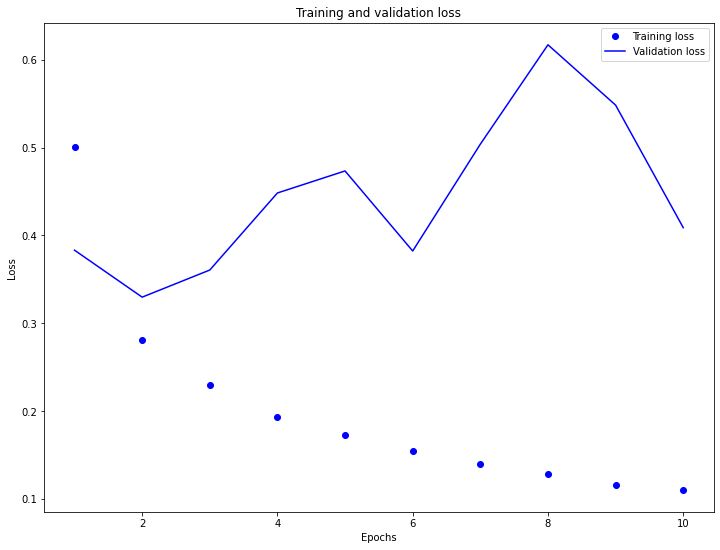

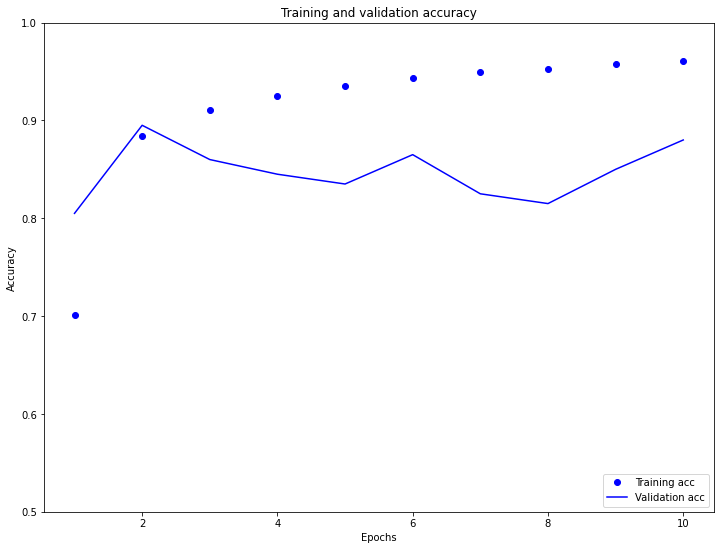

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [18]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn about recurrent networks see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).